In [1]:
library(tidyverse)
library(alakazam)
library(shazam)
library(ggplot2)
library(magrittr)
library(ggpubr)
library(stats)
library(stringr)
library(ggrepel)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

As of v1.0.0 the AIRR Rearrangement schema is now the default file format.
A description of the standard is available at https://docs.airr-community.org.
The legacy Change-O format is supported through arguments to each function
that allow the input column names to be explicitly defined.

As of v1.0.0 the AIRR Rearrangement schema is now the default file format.
A description of the standard is available at https://docs.airr-community.org.
The legacy Change-O format is supported through arguments to each function
that allow the input column names to be explicitly defined.


Attaching package: ‘magrittr’


T

# Read in data

In [2]:
meta <- read.csv('../all_sample_meta.csv', header = T)
files <- dir('../data/')

In [3]:
files 
length(files)

[1] "GW"   "GZR"  "HXR"  "HXR2" "HXX"  "LGY"  "LL"   "LL2"  "MXY"  "QJY" 
[11] "SQ"   "WYF"  "WYF2" "WYY"  "XH"   "XYY"  "XYY2" "ZH"   "ZMY1" "ZPP" 
[21] "ZPP2" "ZS"

[1] 22

In [4]:
tmp <- read.csv('../data/GW/10X_clone-pass_germ-pass.tsv', header = T, sep = '\t')
head(tmp,2)
dim(tmp)

,sequence_id,sequence,rev_comp,productive,v_call,d_call,j_call,sequence_alignment,germline_alignment,junction,⋯,umi_count,v_call_10x,d_call_10x,j_call_10x,junction_10x,junction_10x_aa,germline_alignment_d_mask,germline_v_call,germline_d_call,germline_j_call
,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,TGGCGCAGTCAATGTC-1_contig_1,CTCACTCTGCTGAAGAAAACCAGCCCTGCAGCTCTGGGAGAGGAGCCCCAGCCCTGGGATTCCCAGCTGTTTCTGCTTGCTGATCAGGACTGCACACAGAGAACTCACCATGGAGTTTGGGCTGAGCTGGGTTTTCCTTGTTGCTATTTTAAAAGGTGTCCAGTGTGAGGTGCAGCTGGTGGAGTCCGGGGGAGGCTTAGTTCAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTCAGTAGCTACTGGATGCACTGGGTCCGCCAAGCTCCAGGGAAGGGGCTGGTGTGGGTCTCACGTATTAATAGTGATGGGAGTAGCACAAGCTACGCGGACTCCGTGAAGGGCCGATTCACCATCTCCAGAGACAACGCCAAGAACACGCTGTATCTGCAAATGAACAGTCTGAGAGCCGAGGACACGGCTGTGTATTACTGTGCAAGAGCCCAGTCTTATTACTATGATAGTAGTGGTTATTACTACGAGGGGGGCTTTGACTACTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAGGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGAATTCCCCGTCGGATACGAGCAGCGTG,FALSE,TRUE,IGHV3-74*01,IGHD3-22*01,IGHJ4*02,GAGGTGCAGCTGGTGGAGTCCGGGGGA...GGCTTAGTTCAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTC............AGTAGCTACTGGATGCACTGGGTCCGCCAAGCTCCAGGGAAGGGGCTGGTGTGGGTCTCACGTATTAATAGTGAT......GGGAGTAGCACAAGCTACGCGGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAACGCCAAGAACACGCTGTATCTGCAAATGAACAGTCTGAGAGCCGAGGACACGGCTGTGTATTACTGTGCAAGAGCCCAGTCTTATTACTATGATAGTAGTGGTTATTACTACGAGGGGGGCTTTGACTACTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG,GAGGTGCAGCTGGTGGAGTCCGGGGGA...GGCTTAGTTCAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTC............AGTAGCTACTGGATGCACTGGGTCCGCCAAGCTCCAGGGAAGGGGCTGGTGTGGGTCTCACGTATTAATAGTGAT......GGGAGTAGCACAAGCTACGCGGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAACGCCAAGAACACGCTGTATCTGCAAATGAACAGTCTGAGAGCCGAGGACACGGCTGTGTATTACTGTGCAAGAGNNNNNNNNTATTACTATGATAGTAGTGGTTATTACTACNNNNNNNNCTTTGACTACTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG,TGTGCAAGAGCCCAGTCTTATTACTATGATAGTAGTGGTTATTACTACGAGGGGGGCTTTGACTACTGG,⋯,49,IGHV3-74,IGHD3-22,IGHJ4,TGTGCAAGAGCCCAGTCTTATTACTATGATAGTAGTGGTTATTACTACGAGGGGGGCTTTGACTACTGG,CARAQSYYYDSSGYYYEGGFDYW,GAGGTGCAGCTGGTGGAGTCCGGGGGA...GGCTTAGTTCAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTC............AGTAGCTACTGGATGCACTGGGTCCGCCAAGCTCCAGGGAAGGGGCTGGTGTGGGTCTCACGTATTAATAGTGAT......GGGAGTAGCACAAGCTACGCGGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAACGCCAAGAACACGCTGTATCTGCAAATGAACAGTCTGAGAGCCGAGGACACGGCTGTGTATTACTGTGCAAGAGNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCTTTGACTACTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG,IGHV3-74*01,IGHD3-22*01,IGHJ4*02
2,CTGCTGTGTTGGTTTG-1_contig_2,GAGCTCTGGGAGAGGAGCCCAGCACTAGAAGTCGGCGGTGTTTCCATTCGGTGATCAGCACTGAACACAGAGGACTCACCATGGAGTTTGGGCTGAGCTGGGTTTTCCTCGTTGCTCTTTTAAGAGGTGTCCAGTGTCAGGTGCAGCTGGTGGAGTCTGGGGGAGGCGTGGTCCAGCCTGGGAGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTCAGTAGCTATGCTATGCACTGGGTCCGCCAGGCTCCAGGCAAGGGGCTGGAGTGGGTGGCAGTTATATCATATGATGGAAGTAATAAATACTATGCAGACTCCGTGAAGGGCCGATTCACCATCTCCAGAGACAATTCCAAGAACACGCTGTATCTGCAAATGAACAGCCTGAGAGCTGAGGACACGGCTGTGTATTACTGTGCGAAAGATTCGGAAACATGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAGGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGAATTCCCCGTCGGATACGAGCAGCGTG,FALSE,TRUE,"IGHV3-30*04,IGHV3-30*18,IGHV3-30-3*03","IGHD1-14*01,IGHD3-10*01,IGHD3-10*02","IGHJ4*02,IGHJ5*02",CAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCGTGGTCCAGCCTGGGAGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTC............AGTAGCTATGCTATGCACTGGGTCCGCCAGGCTCCAGGCAAGGGGCTGGAGTGGGTGGCAGTTATATCATATGAT......GGAAGTAATAAATACTATGCAGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAATTCCAAGAACACGCTGTATCTGCAAATGAACAGCCTGAGAGCTGAGGACACGGCTGTGTATTACTGTGCGAAAGATTCGGAAACATGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG,CAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCGTGGTCCAGCCTGGGAGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTC............AGTAGCTATGCTATGCACTGGGTCCGCCAGGCTCCAGGCAAGGGGCTGGAGTGGGTGGCAGTTATATCATATGAT......GGAAGTAATAAATACTACGCAGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAATTCCAAGAACACGCTGTATCTGCAAATGAACAGCCTGAGAGCTGAGGACACGGCTGTGTATTACTGTGCGAGAGANNCGGAANNNTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG,TGTGCGAAAGATTCGGAAACATGG,⋯,19,IGHV3-30,,IGHJ4,TG

[1] 1067   62

In [5]:
# different Ig class ratio 
HC_df <- data.frame(matrix(NA, ncol = dim(tmp)[2] + 1, nrow = 0))
SLE_df <- data.frame(matrix(NA, ncol = dim(tmp)[2] + 1, nrow = 0))
for (file in files){
    name = str_split(file,'_')[[1]][1]
    # assign(name, read.csv(paste0('./vdj/VDJtools/bcr_data/',file),header = T))
    tmp <-  read.csv(paste0('../data/',file,'/10X_clone-pass_germ-pass.tsv'),header = T,sep = '\t')
    tmp %<>% mutate(sample = name)
    if(meta$group[which(meta$name == name)] == 'HC' ){
        HC_df <- rbind(HC_df,tmp)
    }else if(meta$group[which(meta$name == name)] == 'SLE'){
        SLE_df <- rbind(SLE_df, tmp)
    }
}


In [6]:
dim(HC_df)
dim(SLE_df)

[1] 4913   63

[1] 32888    63

In [7]:
SLE_df$disease <- 'SLE'
HC_df$disease <- 'HC'
all_df <-rbind(SLE_df, HC_df)

# remove the cell without RNA

In [8]:
bcell_rna_meta <- read.csv('./seurat_bcell_filter_meta.csv')
plasma_rna_meta <- read.csv('./seurat_plasma_filter_meta.csv')
bcell_rna_meta <- bcell_rna_meta[,c('X','orig.ident','nCount_RNA','nFeature_RNA','group','treatment','pair','percent_mito','percent_ribo','S.Score','G2M.Score','Phase','old.ident','RNA_snn_res.0.8','RNA_snn_res.1','seurat_clusters','main_type','subtype')]
plasma_rna_meta <- plasma_rna_meta[,c('X','orig.ident','nCount_RNA','nFeature_RNA','group','treatment','pair','percent_mito','percent_ribo','S.Score','G2M.Score','Phase','old.ident','RNA_snn_res.0.8','RNA_snn_res.1','seurat_clusters','main_type','subtype')]
rna_meta <- rbind(bcell_rna_meta, plasma_rna_meta)

In [10]:
# rna_meta %>% head()

In [9]:
all_df %>% colnames()

[1] "sequence_id"               "sequence"                 
 [3] "rev_comp"                  "productive"               
 [5] "v_call"                    "d_call"                   
 [7] "j_call"                    "sequence_alignment"       
 [9] "germline_alignment"        "junction"                 
[11] "junction_aa"               "v_cigar"                  
[13] "d_cigar"                   "j_cigar"                  
[15] "stop_codon"                "vj_in_frame"              
[17] "locus"                     "junction_length"          
[19] "np1_length"                "np2_length"               
[21] "v_sequence_start"          "v_sequence_end"           
[23] "v_germline_start"          "v_germline_end"           
[25] "d_sequence_start"          "d_sequence_end"           
[27] "d_germline_start"          "d_germline_end"           
[29] "j_sequence_start"          "j_sequence_end"           
[31] "j_germline_start"          "j_germline_end"           
[33] "v_score"                   "v_identity"               
[35] "v_support"                 "d_score"                  
[37] "d_identity"                "d_support"                
[39] "j_score"                   "j_identity"               
[41] "j_support"                 "fwr1"                     
[43] "fwr2"                      "fwr3"                     
[45] "fwr4"                      "cdr1"                     
[47] "cdr2"                      "cdr3"                     
[49] "cell_id"                   "c_call"                   
[51] "consensus_count"           "clone_id"                 
[53] "umi_count"                 "v_call_10x"               
[55] "d_call_10x"                "j_call_10x"               
[57] "junction_10x"              "junction_10x_aa"          
[59] "germline_alignment_d_mask" "germline_v_call"          
[61] "germline_d_call"           "germline_j_call"          
[63] "sample"                    "disease"

In [10]:
all_df$barcode_match <- paste0(all_df$sample,'_',all_df$disease,'_',str_split_fixed(all_df$sequence_id, '_',n = 3)[,1])

In [11]:
all_df$barcode_match %>% length()
rna_meta$X %>% length()

[1] 37801

[1] 26037

In [12]:
intersect(all_df$barcode_match, rna_meta$X ) %>% length()

[1] 24027

In [13]:
filter_all_df <- all_df[which(all_df$barcode_match %in% rna_meta$X),]
filter_all_df %>% dim()

[1] 24027    65

In [14]:
filter_all_df <- left_join(filter_all_df, rna_meta, by = c('barcode_match' = 'X'))

In [15]:
filter_all_df %>% colnames()

[1] "sequence_id"               "sequence"                 
 [3] "rev_comp"                  "productive"               
 [5] "v_call"                    "d_call"                   
 [7] "j_call"                    "sequence_alignment"       
 [9] "germline_alignment"        "junction"                 
[11] "junction_aa"               "v_cigar"                  
[13] "d_cigar"                   "j_cigar"                  
[15] "stop_codon"                "vj_in_frame"              
[17] "locus"                     "junction_length"          
[19] "np1_length"                "np2_length"               
[21] "v_sequence_start"          "v_sequence_end"           
[23] "v_germline_start"          "v_germline_end"           
[25] "d_sequence_start"          "d_sequence_end"           
[27] "d_germline_start"          "d_germline_end"           
[29] "j_sequence_start"          "j_sequence_end"           
[31] "j_germline_start"          "j_germline_end"           
[33] "v_score"                   "v_identity"               
[35] "v_support"                 "d_score"                  
[37] "d_identity"                "d_support"                
[39] "j_score"                   "j_identity"               
[41] "j_support"                 "fwr1"                     
[43] "fwr2"                      "fwr3"                     
[45] "fwr4"                      "cdr1"                     
[47] "cdr2"                      "cdr3"                     
[49] "cell_id"                   "c_call"                   
[51] "consensus_count"           "clone_id"                 
[53] "umi_count"                 "v_call_10x"               
[55] "d_call_10x"                "j_call_10x"               
[57] "junction_10x"              "junction_10x_aa"          
[59] "germline_alignment_d_mask" "germline_v_call"          
[61] "germline_d_call"           "germline_j_call"          
[63] "sample"                    "disease"                  
[65] "barcode_match"             "orig.ident"               
[67] "nCount_RNA"                "nFeature_RNA"             
[69] "group"                     "treatment"                
[71] "pair"                      "percent_mito"             
[73] "percent_ribo"              "S.Score"                  
[75] "G2M.Score"                 "Phase"                    
[77] "old.ident"                 "RNA_snn_res.0.8"          
[79] "RNA_snn_res.1"             "seurat_clusters"          
[81] "main_type"                 "subtype"

In [16]:
v_j_combine <- filter_all_df %>% select(c('v_call','j_call','disease','subtype','orig.ident')) %>% mutate(combine = (grepl('IGHV3-23',.[,1]) + grepl('IGHJ4',.[,2])) ) %>% filter(combine == 2)
v_j_combine[1:5,]

,v_call,j_call,disease,subtype,orig.ident,combine
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,"IGHV3-23*01,IGHV3-23D*01",IGHJ4*02,SLE,B.transition,GW,2
2,"IGHV3-23*01,IGHV3-23D*01",IGHJ4*02,SLE,B.naive,GW,2
3,"IGHV3-23*01,IGHV3-23D*01",IGHJ4*02,SLE,B.mem,GW,2
4,"IGHV3-23*01,IGHV3-23D*01",IGHJ4*02,SLE,B.IFN-response,GW,2
5,"IGHV3-23*01,IGHV3-23D*01",IGHJ4*02,SLE,B.naive,GW,2


In [17]:
dim(v_j_combine)

[1] 1378    6

# SHM

In [54]:
# db_obs_hc <- observedMutations(HC_df, sequenceColumn="sequence_alignment",
#                             germlineColumn="germline_alignment_d_mask",
#                             regionDefinition=NULL,
#                             frequency=TRUE, 
#                             nproc=24)
# db_obs_sle <- observedMutations(SLE_df, sequenceColumn="sequence_alignment",
#                             germlineColumn="germline_alignment_d_mask",
#                             regionDefinition=NULL,
#                             frequency=TRUE, 
#                             nproc=32)
# db_obs_hc$disease <- 'HC'
# db_obs_sle$disease <- 'SLE'
# db_obs_all <- rbind(db_obs_hc,db_obs_sle)
# db_obs_all %<>% filter(c_call != ',')

In [26]:
db_obs_all <- observedMutations(filter_all_df, sequenceColumn="sequence_alignment",
                            germlineColumn="germline_alignment_d_mask",
                            regionDefinition=NULL,
                            frequency=TRUE, 
                            nproc=32)
db_obs_all %<>% filter(c_call != '')

In [140]:
colnames(filter_all_df)

[1] "sequence_id"               "sequence"                 
 [3] "rev_comp"                  "productive"               
 [5] "v_call"                    "d_call"                   
 [7] "j_call"                    "sequence_alignment"       
 [9] "germline_alignment"        "junction"                 
[11] "junction_aa"               "v_cigar"                  
[13] "d_cigar"                   "j_cigar"                  
[15] "stop_codon"                "vj_in_frame"              
[17] "locus"                     "junction_length"          
[19] "np1_length"                "np2_length"               
[21] "v_sequence_start"          "v_sequence_end"           
[23] "v_germline_start"          "v_germline_end"           
[25] "d_sequence_start"          "d_sequence_end"           
[27] "d_germline_start"          "d_germline_end"           
[29] "j_sequence_start"          "j_sequence_end"           
[31] "j_germline_start"          "j_germline_end"           
[33] "v_score"                   "v_identity"               
[35] "v_support"                 "d_score"                  
[37] "d_identity"                "d_support"                
[39] "j_score"                   "j_identity"               
[41] "j_support"                 "fwr1"                     
[43] "fwr2"                      "fwr3"                     
[45] "fwr4"                      "cdr1"                     
[47] "cdr2"                      "cdr3"                     
[49] "cell_id"                   "c_call"                   
[51] "consensus_count"           "clone_id"                 
[53] "umi_count"                 "v_call_10x"               
[55] "d_call_10x"                "j_call_10x"               
[57] "junction_10x"              "junction_10x_aa"          
[59] "germline_alignment_d_mask" "germline_v_call"          
[61] "germline_d_call"           "germline_j_call"          
[63] "sample"                    "disease"                  
[65] "barcode_match"

# C gene usage

In [18]:
filter_all_df_sle <- filter_all_df[which(filter_all_df$disease == 'SLE'),]
filter_all_df_hc <- filter_all_df[which(filter_all_df$disease == 'HC'),]
dim(filter_all_df_sle)
dim(filter_all_df_hc)

[1] 20200    82

[1] 3827   82

In [30]:
sle_c_pie_bcell

C gene,main_type,count
<fct>,<fct>,<int>
IGHA1,Bcell,373
IGHA2,Bcell,132
IGHD,Bcell,275
IGHG1,Bcell,906
IGHG2,Bcell,297
IGHG3,Bcell,218
IGHG4,Bcell,5
IGHM,Bcell,10360


Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


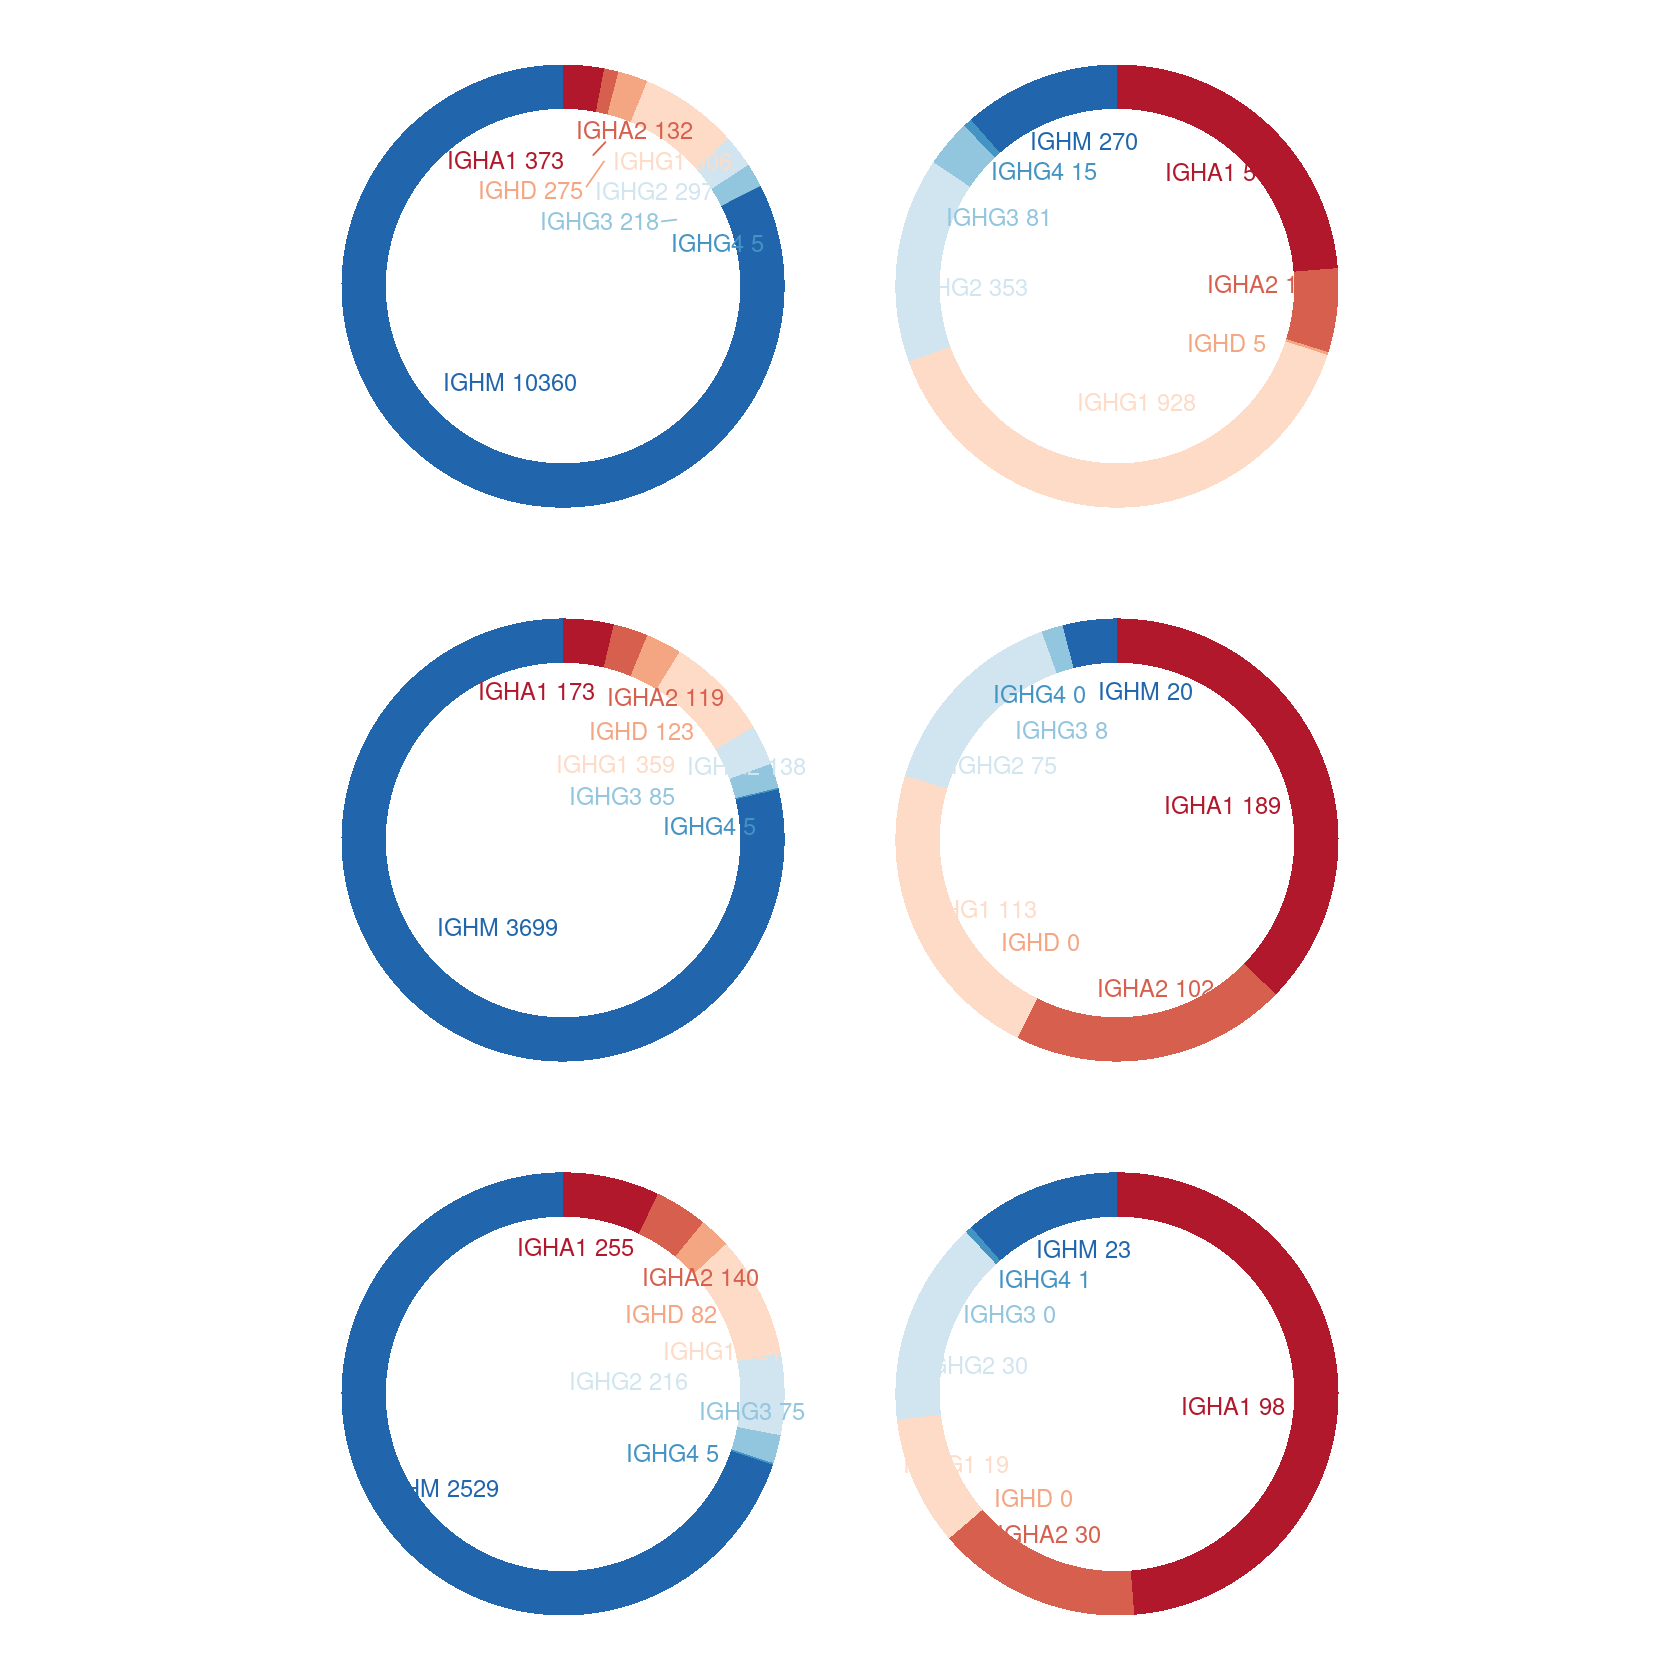

In [33]:
# sle_pre
filter_all_df_sle_before <- filter_all_df_sle %>% filter(treatment == 'untreated')
sle_c_pie <- table(filter_all_df_sle_before$c_call , filter_all_df_sle_before$main_type) %>% data.frame()
sle_c_pie_bcell <- sle_c_pie %>% filter(Var2 == 'Bcell') %>% filter(Var1 != '')
colnames(sle_c_pie_bcell) <- c('C gene','main_type','count')
a <- pie_plot(sle_c_pie_bcell,'count','C gene')

sle_c_pie_plasma <- sle_c_pie %>% filter(Var2 == 'Plasma') %>% filter(Var1 != '')
colnames(sle_c_pie_plasma) <- c('C gene','main_type','count')
b <- pie_plot(sle_c_pie_plasma,'count','C gene')

# sle_after
filter_all_df_sle_after <- filter_all_df_sle %>% filter(treatment == 'treated')
sle_c_pie <- table(filter_all_df_sle_after$c_call , filter_all_df_sle_after$main_type) %>% data.frame()
sle_c_pie_bcell <- sle_c_pie %>% filter(Var2 == 'Bcell') %>% filter(Var1 != '')
colnames(sle_c_pie_bcell) <- c('C gene','main_type','count')
c <- pie_plot(sle_c_pie_bcell,'count','C gene')

sle_c_pie_plasma <- sle_c_pie %>% filter(Var2 == 'Plasma') %>% filter(Var1 != '')
colnames(sle_c_pie_plasma) <- c('C gene','main_type','count')
d <- pie_plot(sle_c_pie_plasma,'count','C gene')


# hc
hc_c_pie <- table(filter_all_df_hc$c_call , filter_all_df_hc$main_type) %>% data.frame()
hc_c_pie_bcell <- hc_c_pie %>% filter(Var2 == 'Bcell') %>% filter(Var1 != '')
colnames(hc_c_pie_bcell) <- c('C gene','main_type','count')
e <- pie_plot(hc_c_pie_bcell,'count','C gene')

hc_c_pie_plasma <- hc_c_pie %>% filter(Var2 == 'Plasma') %>% filter(Var1 != '')
colnames(hc_c_pie_plasma) <- c('C gene','main_type','count')
f <- pie_plot(hc_c_pie_plasma,'count','C gene')

options(repr.plot.width=14, repr.plot.height=14)
library(patchwork)
(a+b)/(c+d)/(e+f)

In [76]:
library(patchwork)

.
B.IFN-response          B.mem    B.mem.CD27-   B.mem.CXCR3+    B.mem.IGHM+ 
          1542           2032           1415           2230           1250 
       B.naive   B.transition         plasma 
         10109           2388           3061 

[1] "HC"
[1] "B.mem"
[1] "B.mem.CD27-"
[1] "B.mem.CXCR3+"
[1] "B.mem.IGHM+"
[1] "plasma"
[1] "treated"
[1] "B.mem"
[1] "B.mem.CD27-"
[1] "B.mem.CXCR3+"
[1] "B.mem.IGHM+"
[1] "plasma"
[1] "untreated"
[1] "B.mem"
[1] "B.mem.CD27-"
[1] "B.mem.CXCR3+"
[1] "B.mem.IGHM+"
[1] "plasma"


Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


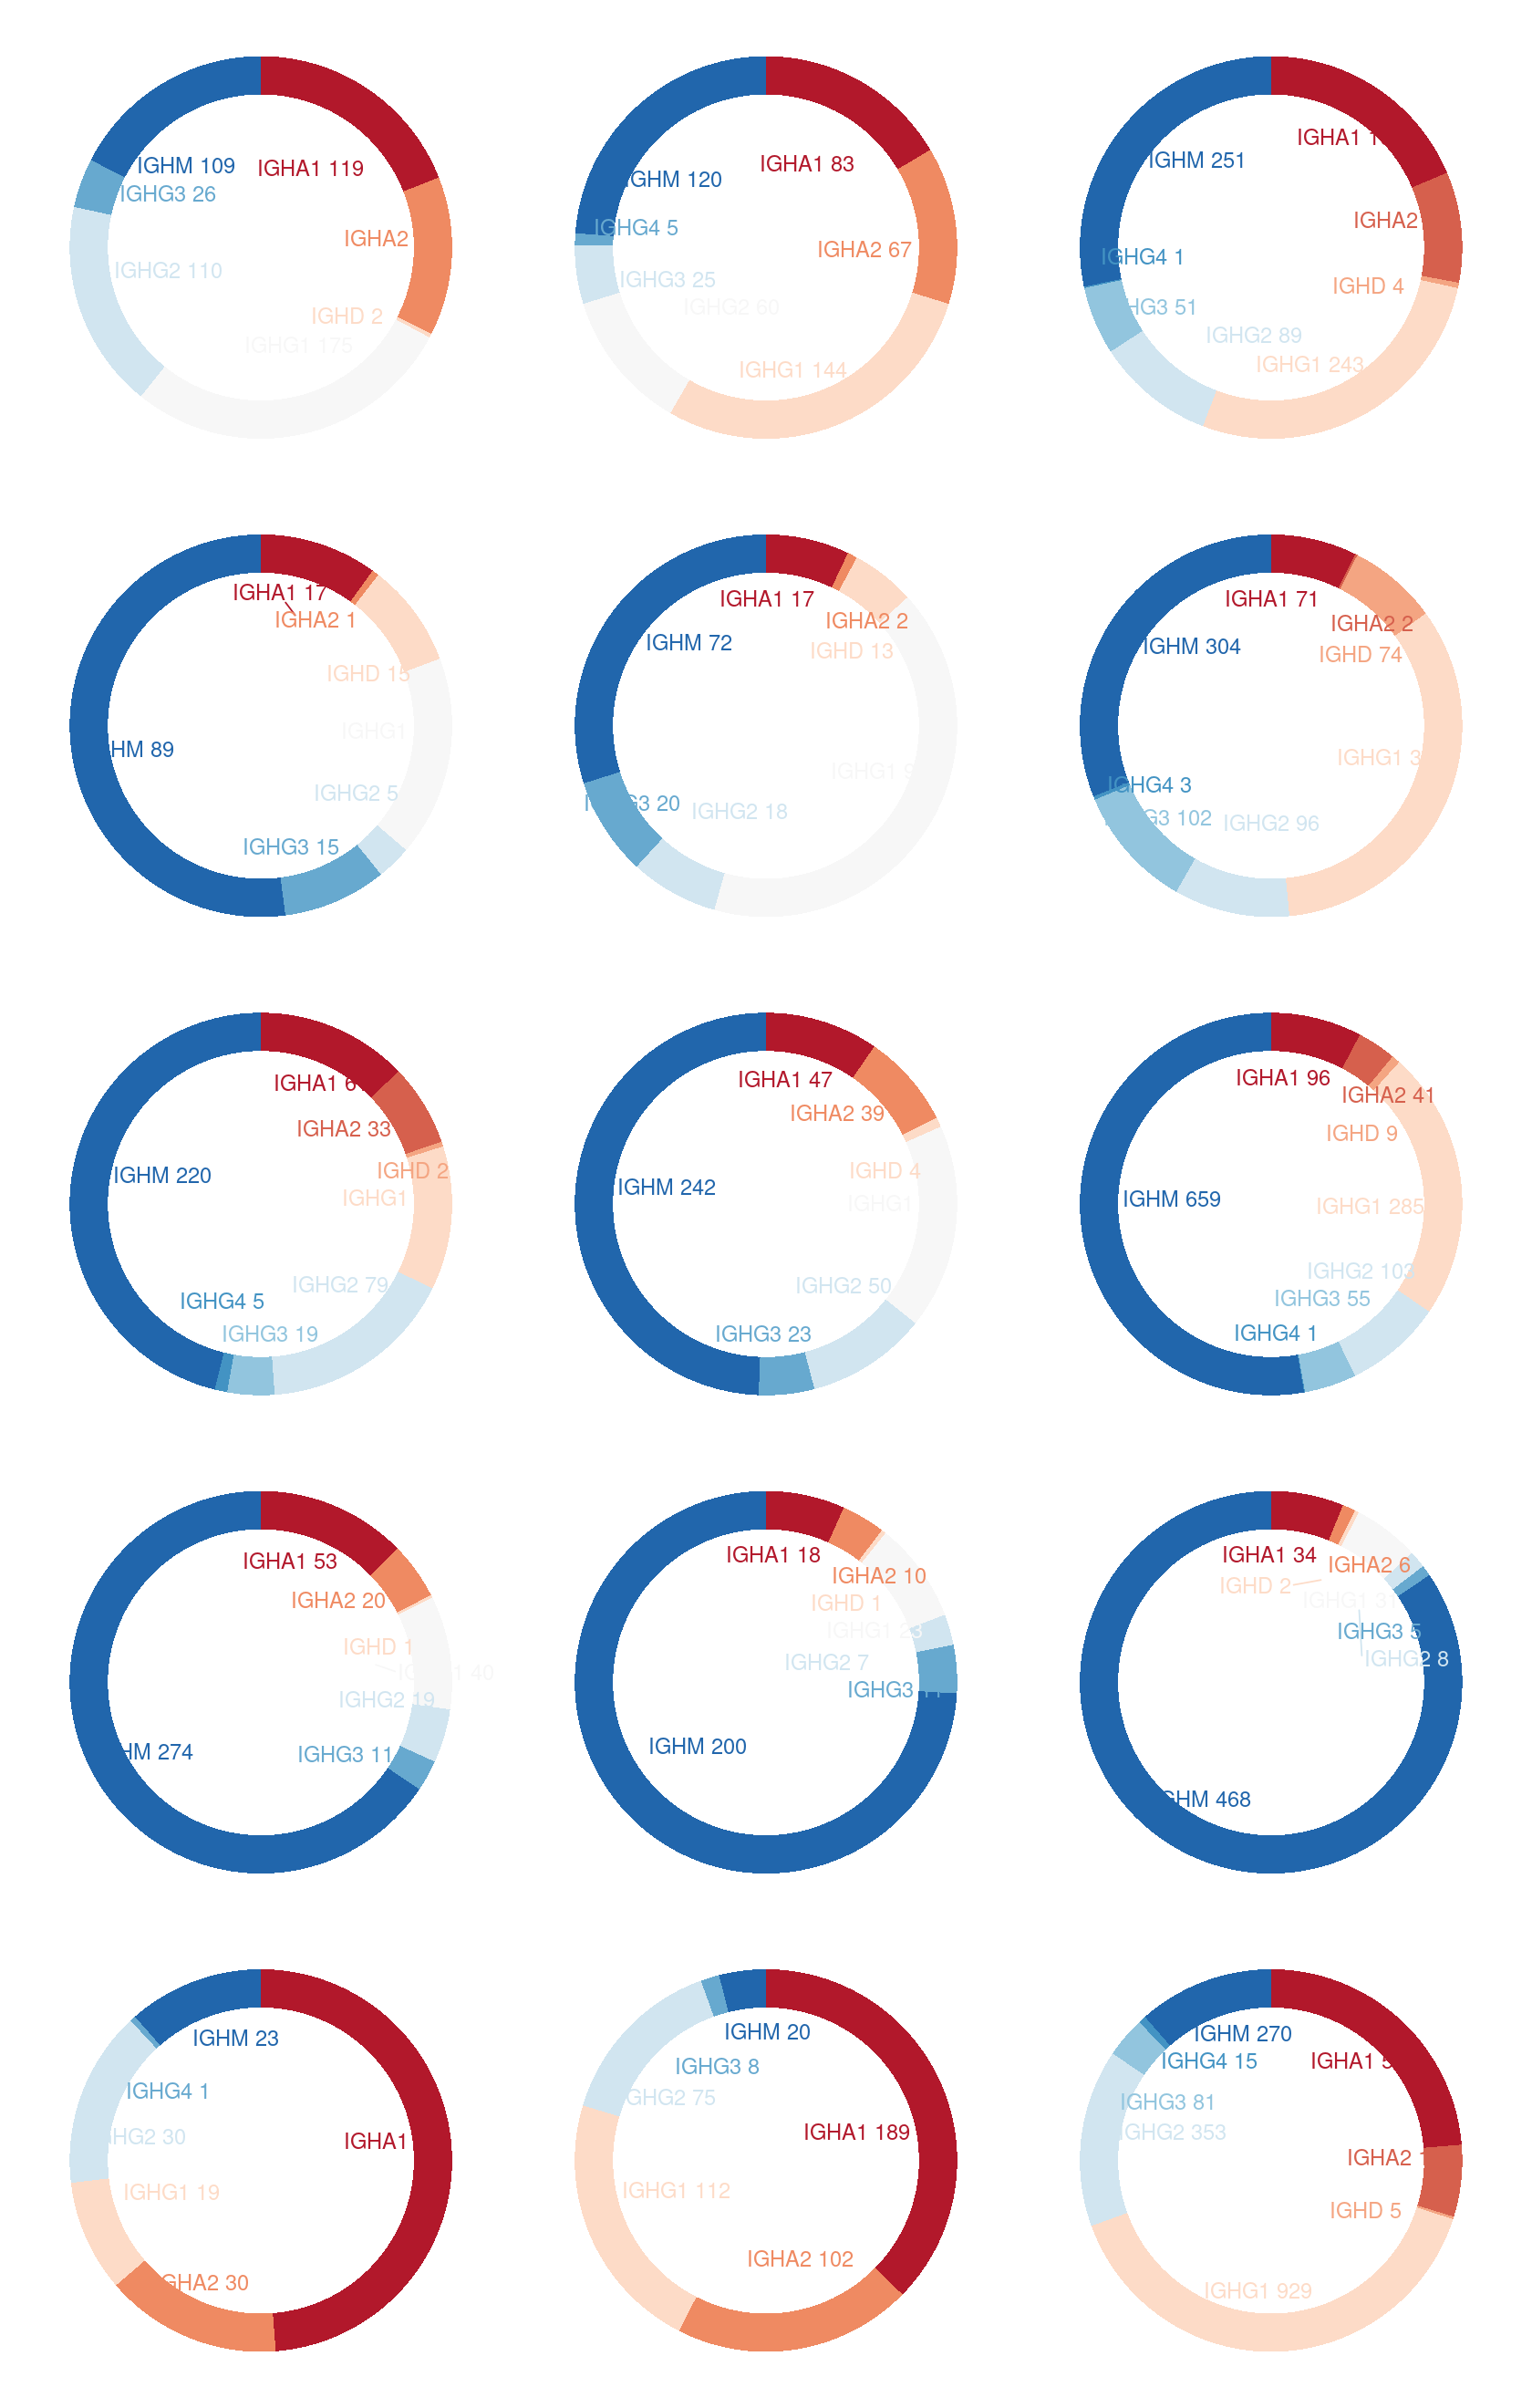

In [101]:
filter_all_df$subtype[grepl(filter_all_df$subtype,pattern = 'plasma')] <- 'plasma'
filter_all_df$subtype %>% table()
sub_filter_all_df <- filter_all_df %>% filter(!subtype %in% c('B.naive','B.IFN-response','B.transition')) 
p2_list <- list();j = 1
for (treatment in c('HC','treated','untreated')) {
    # print(treatment)
    sub <- sub_filter_all_df[which(sub_filter_all_df$treatment == treatment),]
    p_list <- list()
    i = 1
    for (celltype in c('B.mem','B.mem.CD27-','B.mem.CXCR3+','B.mem.IGHM+','plasma')){
        # print(celltype)
        sub2 <- sub[which(sub$subtype == celltype),]
        # plot
        plot_tab <- table(sub2$c_call , sub2$subtype) %>% data.frame() %>% filter(Var1 != '')
        colnames(plot_tab) <- c('C gene','subtype','count')
        p <- pie_plot(plot_tab,'count','C gene')
        p_list[[i]] <- p
        # names(p_list[[i]]) <- paste0(treatment,celltype)
        i = i+1
    }
    p2 <- do.call(patchwork::wrap_plots,c(p_list,ncol =1)) 
    p2_list[[j]] <- p2; j = j+1
}
options(repr.plot.width=14, repr.plot.height=22)
do.call(patchwork::wrap_plots,c(p2_list,ncol =3))


ERROR while rich displaying an object: Error in plot$scales$clone(): attempt to apply non-function

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. 

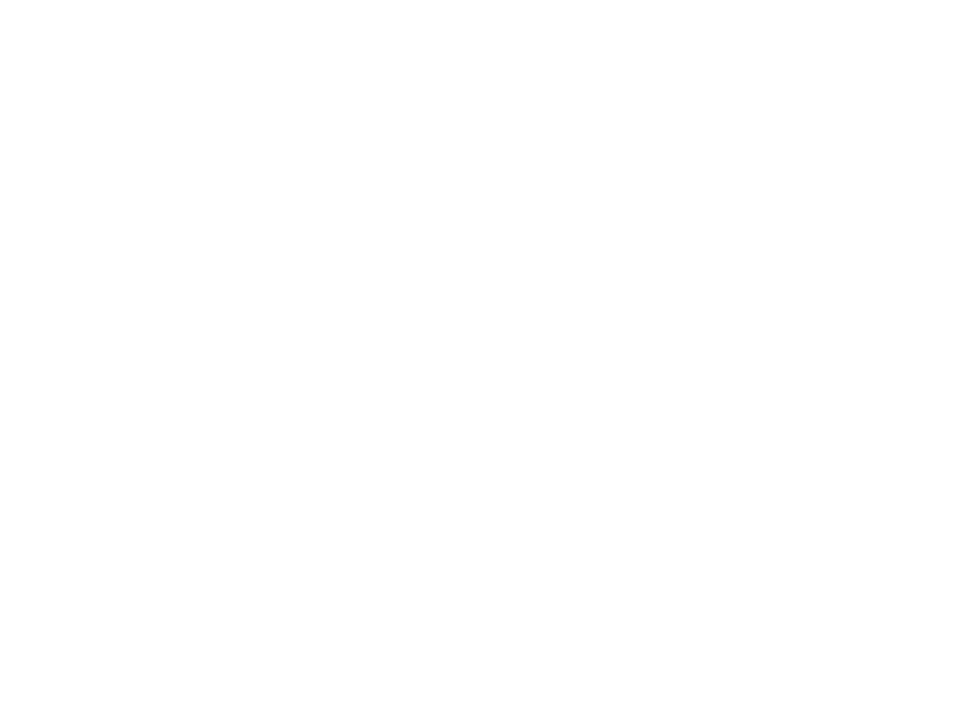

In [31]:
pie_plot <- function(data, count, group, title, out = False){
    # Compute percentages
    data$fraction <- data[[count]] / sum(data[[count]])

    # Compute the cumulative percentages (top of each rectangle)
    data$ymax <- cumsum(data$fraction)

    # Compute the bottom of each rectangle
    data$ymin <- c(0, head(data$ymax, n=-1))

    # Compute label position
    data$labelPosition <- (data$ymax + data$ymin) / 2

    # Compute a good label
    data$label <- paste0(data[[group]], " ", data[[count]])

    # Make the plot
    ggplot(data, aes(ymax=ymax, ymin=ymin, xmax=4, xmin=3, fill=get(group))) +
    geom_rect() +
    geom_text_repel( x=2, aes(y=labelPosition, label=label, color=get(group)), size=5) + # x here controls label position (inner / outer)
    scale_fill_brewer(palette='RdBu') +
    scale_color_brewer(palette='RdBu') +
    coord_polar(theta="y") +
    xlim(c(-1, 4)) +
    theme_void() +
    theme(legend.position = "none")
}

In [41]:
g1 <- ggplot(db_obs_hc, aes(x=c_call, y=mu_freq_seq_r, fill=c_call)) +
    theme_bw() + ggtitle("HC Total mutations") +
    xlab("Isotype") + ylab("Mutation frequency") +
    scale_fill_manual(name="Isotype", values=IG_COLORS) +
    geom_boxplot()
g2 <-ggplot(db_obs_sle, aes(x=c_call, y=mu_freq_seq_r, fill=c_call)) +
    theme_bw() + ggtitle("SLE Total mutations") +
    xlab("Isotype") + ylab("Mutation frequency") +
    scale_fill_manual(name="Isotype", values=IG_COLORS) +
    geom_boxplot()
options(repr.plot.width=12, repr.plot.height=8)
ggarrange(g1, g2)

ERROR: Error in ggplot(db_obs_hc, aes(x = c_call, y = mu_freq_seq_r, fill = c_call)): object 'db_obs_hc' not found


In [27]:
head(db_obs_all)

,sequence_id,sequence,rev_comp,productive,v_call,d_call,j_call,sequence_alignment,germline_alignment,junction,⋯,G2M.Score,Phase,old.ident,RNA_snn_res.0.8,RNA_snn_res.1,seurat_clusters,main_type,subtype,mu_freq_seq_r,mu_freq_seq_s
,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
1,TGGCGCAGTCAATGTC-1_contig_1,CTCACTCTGCTGAAGAAAACCAGCCCTGCAGCTCTGGGAGAGGAGCCCCAGCCCTGGGATTCCCAGCTGTTTCTGCTTGCTGATCAGGACTGCACACAGAGAACTCACCATGGAGTTTGGGCTGAGCTGGGTTTTCCTTGTTGCTATTTTAAAAGGTGTCCAGTGTGAGGTGCAGCTGGTGGAGTCCGGGGGAGGCTTAGTTCAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTCAGTAGCTACTGGATGCACTGGGTCCGCCAAGCTCCAGGGAAGGGGCTGGTGTGGGTCTCACGTATTAATAGTGATGGGAGTAGCACAAGCTACGCGGACTCCGTGAAGGGCCGATTCACCATCTCCAGAGACAACGCCAAGAACACGCTGTATCTGCAAATGAACAGTCTGAGAGCCGAGGACACGGCTGTGTATTACTGTGCAAGAGCCCAGTCTTATTACTATGATAGTAGTGGTTATTACTACGAGGGGGGCTTTGACTACTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAGGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGAATTCCCCGTCGGATACGAGCAGCGTG,FALSE,TRUE,IGHV3-74*01,IGHD3-22*01,IGHJ4*02,GAGGTGCAGCTGGTGGAGTCCGGGGGA...GGCTTAGTTCAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTC............AGTAGCTACTGGATGCACTGGGTCCGCCAAGCTCCAGGGAAGGGGCTGGTGTGGGTCTCACGTATTAATAGTGAT......GGGAGTAGCACAAGCTACGCGGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAACGCCAAGAACACGCTGTATCTGCAAATGAACAGTCTGAGAGCCGAGGACACGGCTGTGTATTACTGTGCAAGAGCCCAGTCTTATTACTATGATAGTAGTGGTTATTACTACGAGGGGGGCTTTGACTACTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG,GAGGTGCAGCTGGTGGAGTCCGGGGGA...GGCTTAGTTCAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTC............AGTAGCTACTGGATGCACTGGGTCCGCCAAGCTCCAGGGAAGGGGCTGGTGTGGGTCTCACGTATTAATAGTGAT......GGGAGTAGCACAAGCTACGCGGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAACGCCAAGAACACGCTGTATCTGCAAATGAACAGTCTGAGAGCCGAGGACACGGCTGTGTATTACTGTGCAAGAGNNNNNNNNTATTACTATGATAGTAGTGGTTATTACTACNNNNNNNNCTTTGACTACTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG,TGTGCAAGAGCCCAGTCTTATTACTATGATAGTAGTGGTTATTACTACGAGGGGGGCTTTGACTACTGG,⋯,-0.008574932,S,1,0,0,0,Bcell,B.naive,0.000000000,0.000000000
2,CTGCTGTGTTGGTTTG-1_contig_2,GAGCTCTGGGAGAGGAGCCCAGCACTAGAAGTCGGCGGTGTTTCCATTCGGTGATCAGCACTGAACACAGAGGACTCACCATGGAGTTTGGGCTGAGCTGGGTTTTCCTCGTTGCTCTTTTAAGAGGTGTCCAGTGTCAGGTGCAGCTGGTGGAGTCTGGGGGAGGCGTGGTCCAGCCTGGGAGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTCAGTAGCTATGCTATGCACTGGGTCCGCCAGGCTCCAGGCAAGGGGCTGGAGTGGGTGGCAGTTATATCATATGATGGAAGTAATAAATACTATGCAGACTCCGTGAAGGGCCGATTCACCATCTCCAGAGACAATTCCAAGAACACGCTGTATCTGCAAATGAACAGCCTGAGAGCTGAGGACACGGCTGTGTATTACTGTGCGAAAGATTCGGAAACATGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAGGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGAATTCCCCGTCGGATACGAGCAGCGTG,FALSE,TRUE,"IGHV3-30*04,IGHV3-30*18,IGHV3-30-3*03","IGHD1-14*01,IGHD3-10*01,IGHD3-10*02","IGHJ4*02,IGHJ5*02",CAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCGTGGTCCAGCCTGGGAGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTC............AGTAGCTATGCTATGCACTGGGTCCGCCAGGCTCCAGGCAAGGGGCTGGAGTGGGTGGCAGTTATATCATATGAT......GGAAGTAATAAATACTATGCAGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAATTCCAAGAACACGCTGTATCTGCAAATGAACAGCCTGAGAGCTGAGGACACGGCTGTGTATTACTGTGCGAAAGATTCGGAAACATGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG,CAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCGTGGTCCAGCCTGGGAGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTC............AGTAGCTATGCTATGCACTGGGTCCGCCAGGCTCCAGGCAAGGGGCTGGAGTGGGTGGCAGTTATATCATATGAT......GGAAGTAATAAATACTACGCAGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAATTCCAAGAACACGCTGTATCTGCAAATGAACAGCCTGAGAGCTGAGGACACGGCTGTGTATTACTGTGCGAGAGANNCGGAANNNTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG,TGTGCGAAAGATTCGGAAACATGG,⋯,0.058863848,G2M,0,1,1,1,Bcell,B.naive,0.003039514,0.003039514
3,CCCATACGTTGAGGTG-1_contig_1,GGGGGACTCAACAACCACATCTGTCCTCTAGAGAAAACCCTGTGAGCACAGCTCCTCACCATGGACTGGACCTGGAGGATCCTCTTCTTGGTGGCAGCAGCTACAAGTGCCCACTCCCAGGTGCAGCTGGTGCAGTCTGGGGCTGAGGTGAAGAAGCCTGGGGCCTCAGTGAAGGTCTCCTGCAAGGCTTCTGGATACACCTTCACCAGTTATGATATCAACTGGGTGCGACAGGCCACTGGACAAGGGCTTGAGTGGATGGGATGGATGAACCCTAACAGTGGTAACACAGGCTATGCACAGAAGTTCCAGGGCAGAGTCACCATGACCAGGAACACCTCCATAAGCACAGCCTACATGGAGCTGAGCAGCCTGAGATCTGAGGACACGGCCGTGTATTACTGTGCGAGAGAGGGTGGTCCCTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAGGGA

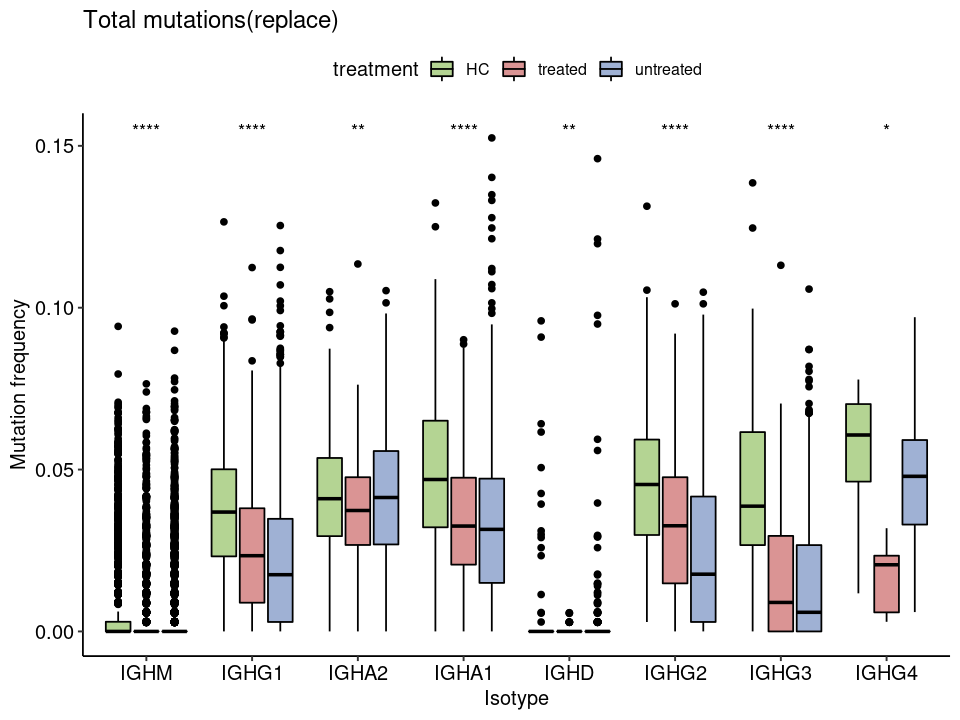

In [38]:
options(repr.plot.width=8, repr.plot.height=6)
ggboxplot(db_obs_all, "c_call", "mu_freq_seq_r", fill = "treatment",
 palette =  c("#B4D493", "#DA9494","#9FB1D4")) + ggtitle("Total mutations(replace)") +
    xlab("Isotype") + ylab("Mutation frequency")  +
    theme_pubr() + stat_compare_means(aes(group = treatment ), label = "p.signif", method = 'anova')

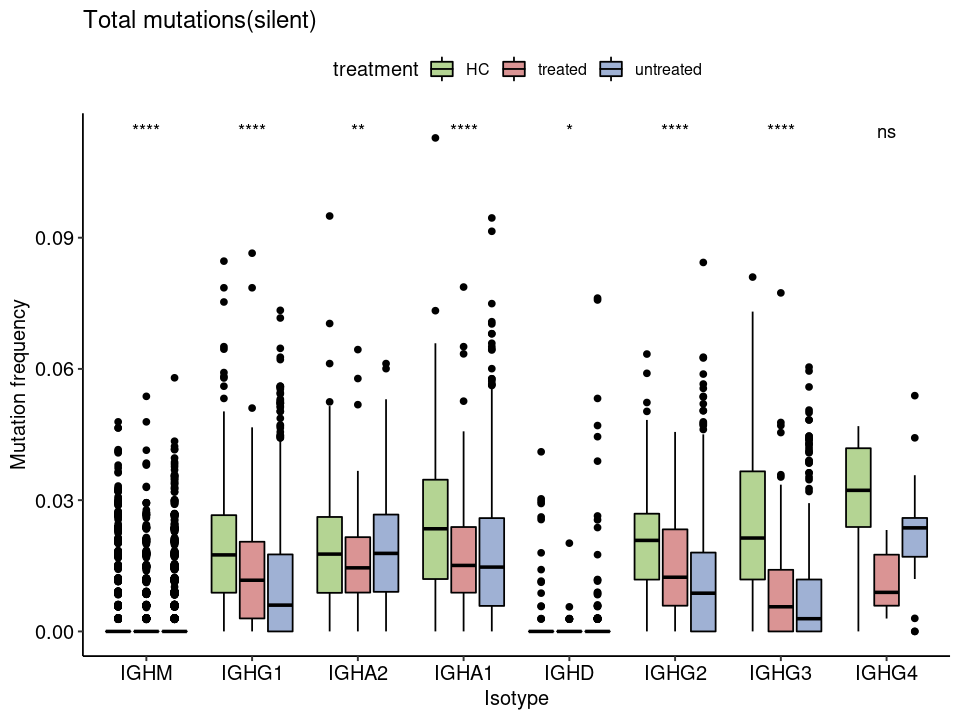

In [40]:
options(repr.plot.width=8, repr.plot.height=6)
ggboxplot(db_obs_all, "c_call", "mu_freq_seq_s", fill = "treatment",
 palette =  c("#B4D493", "#DA9494","#9FB1D4")) + ggtitle("Total mutations(silent)") +
    xlab("Isotype") + ylab("Mutation frequency")  +
    theme_pubr() + stat_compare_means(aes(group = treatment ), label = "p.signif", method = 'anova')

In [14]:
db_obs_all %>% colnames()

[1] "sequence_id"               "sequence"                 
 [3] "rev_comp"                  "productive"               
 [5] "v_call"                    "d_call"                   
 [7] "j_call"                    "sequence_alignment"       
 [9] "germline_alignment"        "junction"                 
[11] "junction_aa"               "v_cigar"                  
[13] "d_cigar"                   "j_cigar"                  
[15] "stop_codon"                "vj_in_frame"              
[17] "locus"                     "junction_length"          
[19] "np1_length"                "np2_length"               
[21] "v_sequence_start"          "v_sequence_end"           
[23] "v_germline_start"          "v_germline_end"           
[25] "d_sequence_start"          "d_sequence_end"           
[27] "d_germline_start"          "d_germline_end"           
[29] "j_sequence_start"          "j_sequence_end"           
[31] "j_germline_start"          "j_germline_end"           
[33] "v_score"                   "v_identity"               
[35] "v_support"                 "d_score"                  
[37] "d_identity"                "d_support"                
[39] "j_score"                   "j_identity"               
[41] "j_support"                 "fwr1"                     
[43] "fwr2"                      "fwr3"                     
[45] "fwr4"                      "cdr1"                     
[47] "cdr2"                      "cdr3"                     
[49] "cell_id"                   "c_call"                   
[51] "consensus_count"           "clone_id"                 
[53] "umi_count"                 "v_call_10x"               
[55] "d_call_10x"                "j_call_10x"               
[57] "junction_10x"              "junction_10x_aa"          
[59] "germline_alignment_d_mask" "germline_v_call"          
[61] "germline_d_call"           "germline_j_call"          
[63] "sample"                    "disease"                  
[65] "mu_freq_seq_r"             "mu_freq_seq_s"

In [16]:
write.csv(db_obs_all,'/rd2/user/xiacr/sle/scripts/immcantaion/bcell_immacantation_SHM.csv')

# SHM target model

In [77]:
# Create substitution model using silent mutations
sub_model <- createSubstitutionMatrix(filter_all_df, model="s", 
                                      sequenceColumn="sequence_alignment",
                                      germlineColumn="germline_alignment_d_mask",
                                      vCallColumn="v_call")

In [78]:
model <- createTargetingModel(filter_all_df, model="s", sequenceColumn="sequence_alignment", 
                              germlineColumn="germline_alignment_d_mask", vCallColumn="v_call")

Warning message in createMutabilityMatrix(db, sub_mat, model = model, sequenceColumn = sequenceColumn, :
“Insufficient number of mutations to infer some 5-mers. Filled with 0. ”


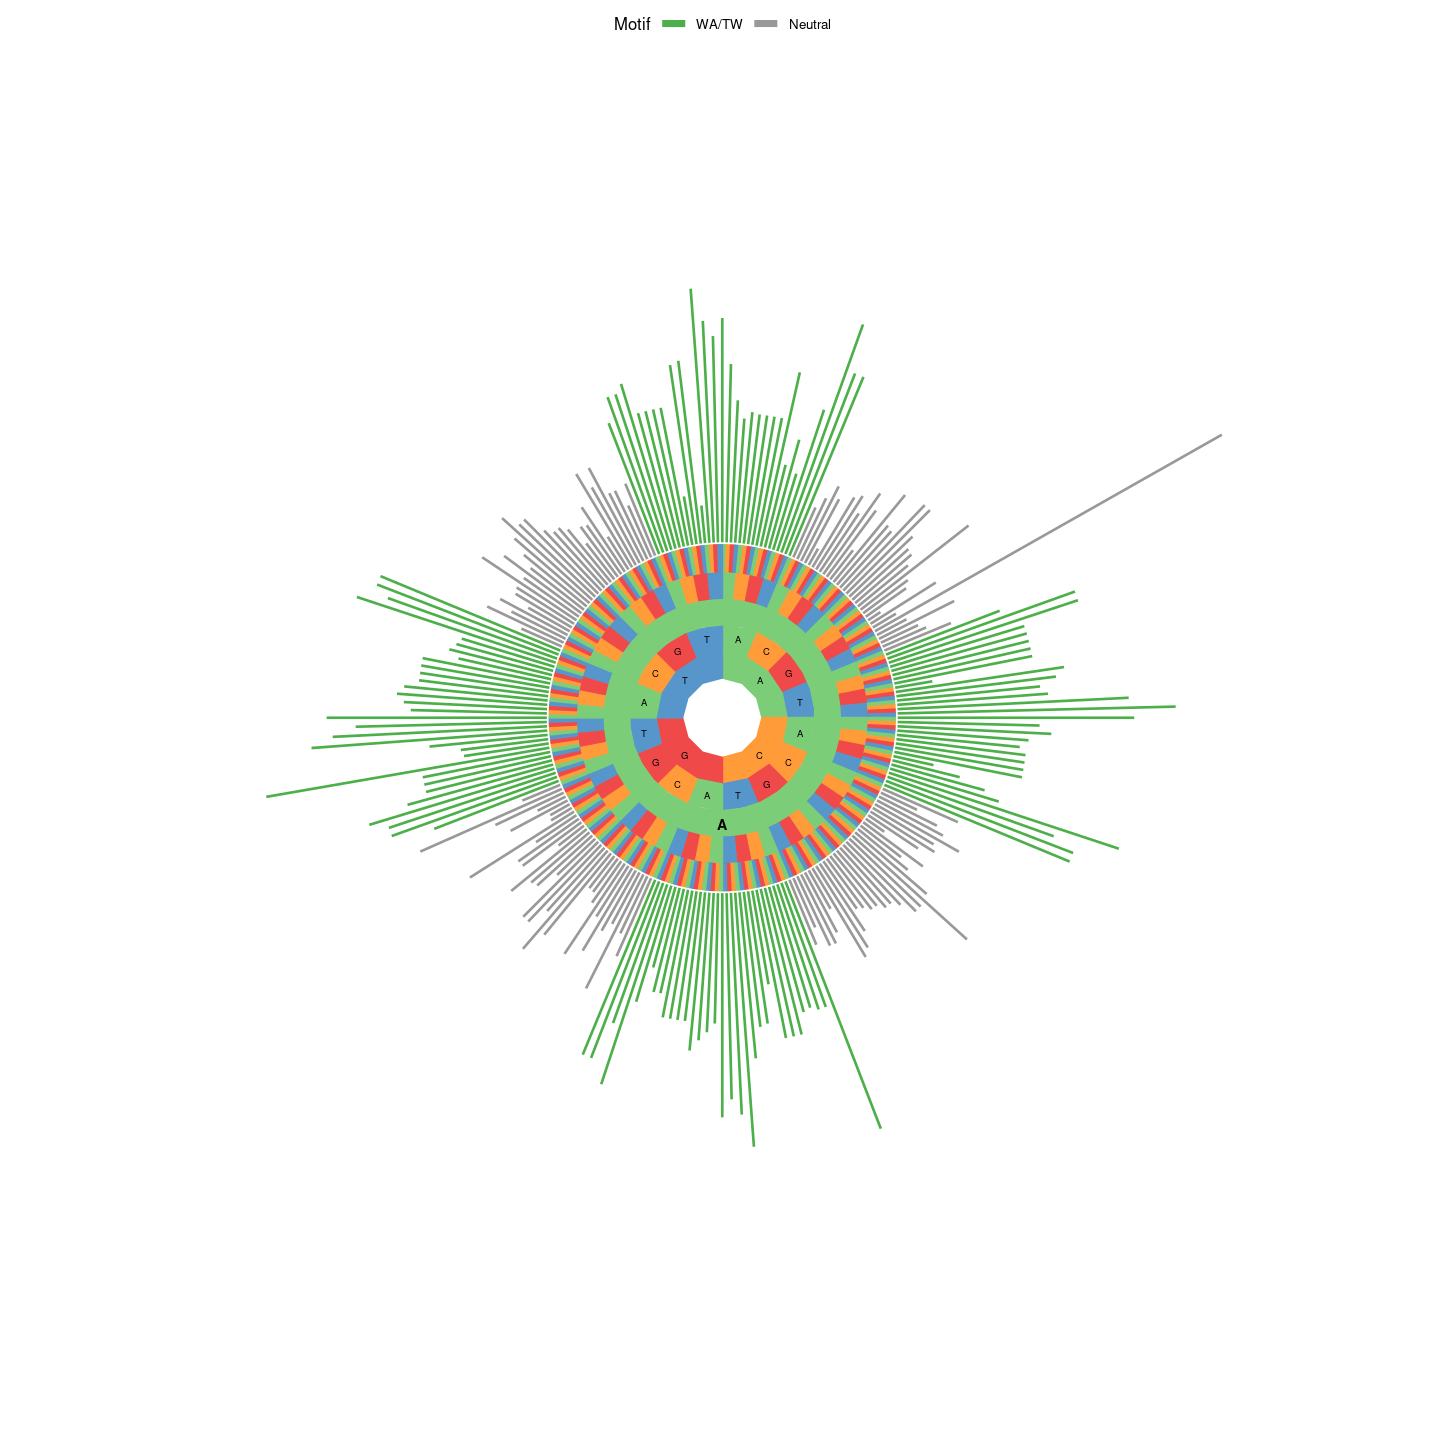

In [87]:
options(repr.plot.width=12, repr.plot.height=12)
plotMutability(model, nucleotides="A", style="hedgehog", size = 1)

# gene usage

In [18]:
# gene_usage_hc <- countGenes(HC_df, gene="v_call", groups="sample", mode="gene")
# gene_usage_sle <- countGenes(SLE_df, gene="v_call", groups="sample", mode="gene")
 gene_usage_all <- countGenes(filter_all_df, gene="v_call", groups="sample", mode="gene")

In [25]:
unique(filter_all_df[,c('orig.ident','group')])

,orig.ident,group
,<chr>,<chr>
1,GW,SLE
809,GZR,SLE
1678,HXR,SLE
3223,HXR2,SLE
3787,HXX,SLE
6483,LGY,SLE
9170,LL,SLE
9363,LL2,SLE
9928,MXY,SLE


In [49]:
unique(filter_all_df[,c('orig.ident','group')]) %>% write.csv('meta.csv')

In [27]:
gene_usage_all %<>% left_join(unique(filter_all_df[,c('orig.ident','group')]), by = c('sample' = 'orig.ident'))

In [32]:
gene_usage_all %<>% arrange(gene)

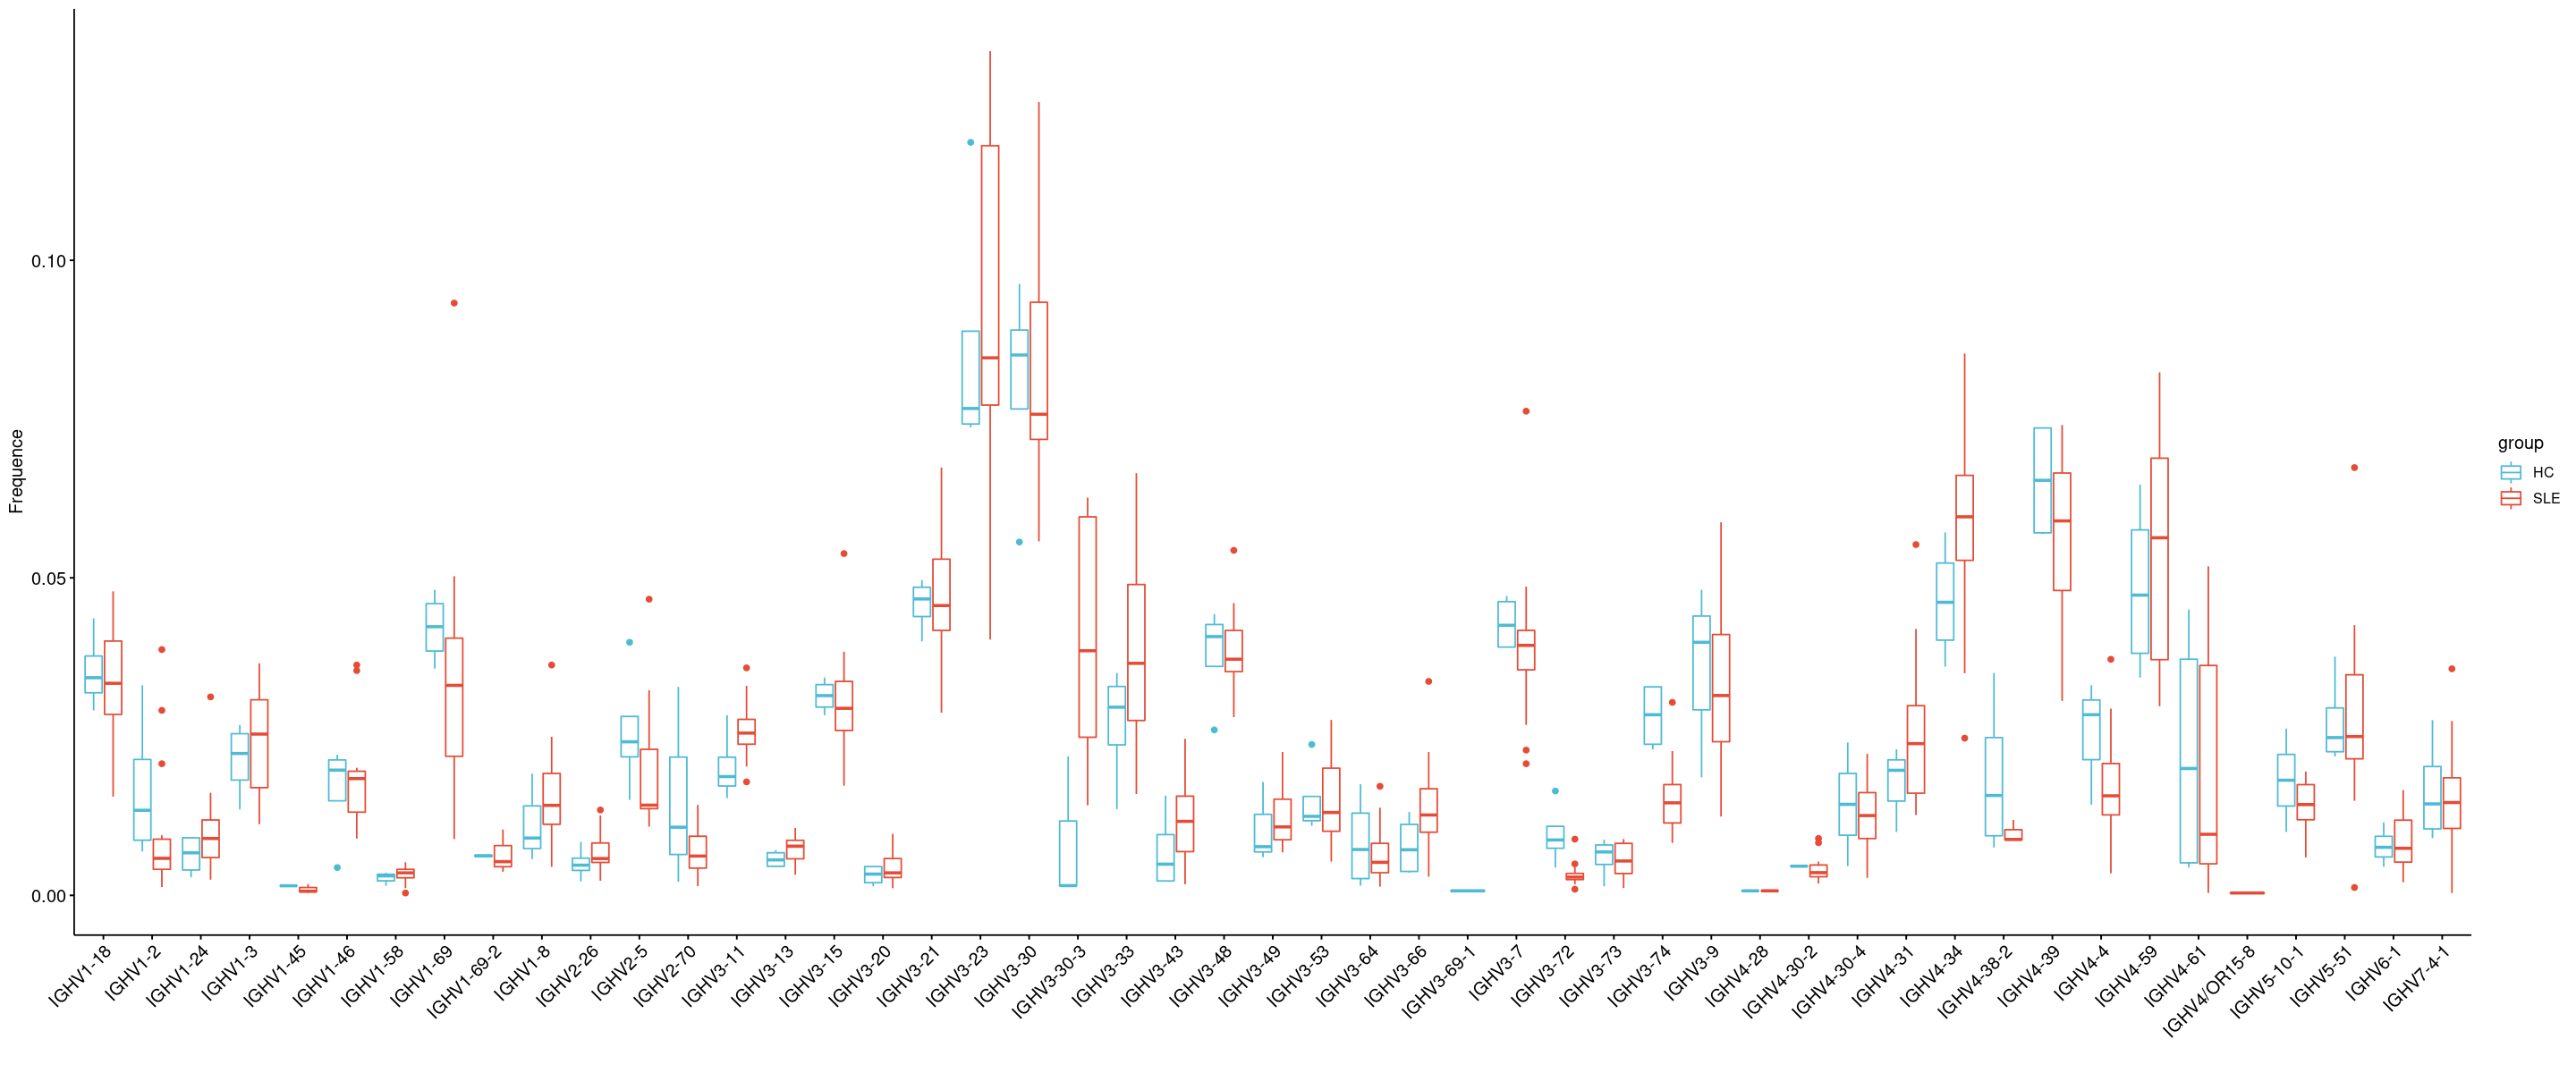

In [50]:
options(repr.plot.width=24, repr.plot.height=10)
ggboxplot(gene_usage_all, "gene", "seq_freq", color = "group",palette = c('#4EBBD5','#E64B35'), legend = 'right') +  theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('Frequence')

In [192]:
ighv1 <- gene_usage_all %>%
    mutate(gene=factor(gene, levels=sortGenes(unique(gene), method="name"))) %>%
    filter(getFamily(gene) == "IGHV1") %>% left_join(meta,by = c('sample'='name'))

# Plot V gene usage in the IGHV1 family by sample
g1 <- ggplot(ighv1, aes(x=gene, y=seq_freq)) +
    theme_bw() +
    ggtitle("IGHV1 Usage") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    ylab("Percent of repertoire") +
    xlab("") +
    # scale_y_continuous(labels=percent) +
    scale_color_brewer(palette="Set2") +
    geom_point(aes(color=group), size=2, alpha=0.6)

# IGV2
g2 <- gene_usage_all %>%
    mutate(gene=factor(gene, levels=sortGenes(unique(gene), method="name"))) %>%
    filter(getFamily(gene) == "IGHV2") %>% left_join(meta,by = c('sample'='name')) %>%
    ggplot(aes(x=gene, y=seq_freq)) +
    theme_bw() +ggtitle("IGHV2 Usage") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    ylab("Percent of repertoire") +xlab("") +
    # scale_y_continuous(labels=percent) +
    scale_color_brewer(palette="Set2") +
    geom_point(aes(color=group), size=2, alpha=0.6)

# IGV3
g3 <- gene_usage_all %>%
    mutate(gene=factor(gene, levels=sortGenes(unique(gene), method="name"))) %>%
    filter(getFamily(gene) == "IGHV3") %>% left_join(meta,by = c('sample'='name')) %>%
    ggplot(aes(x=gene, y=seq_freq)) +
    theme_bw() +ggtitle("IGHV3 Usage") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    ylab("Percent of repertoire") +xlab("") +
    # scale_y_continuous(labels=percent) +
    scale_color_brewer(palette="Set2") +
    geom_point(aes(color=group), size=2, alpha=0.6)

# IGV4
g4 <- gene_usage_all %>%
    mutate(gene=factor(gene, levels=sortGenes(unique(gene), method="name"))) %>%
    filter(getFamily(gene) == "IGHV4") %>% left_join(meta,by = c('sample'='name')) %>%
    ggplot(aes(x=gene, y=seq_freq)) +
    theme_bw() +ggtitle("IGHV4 Usage") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    ylab("Percent of repertoire") +xlab("") +
    # scale_y_continuous(labels=percent) +
    scale_color_brewer(palette="Set2") +
    geom_point(aes(color=group), size=2, alpha=0.6)


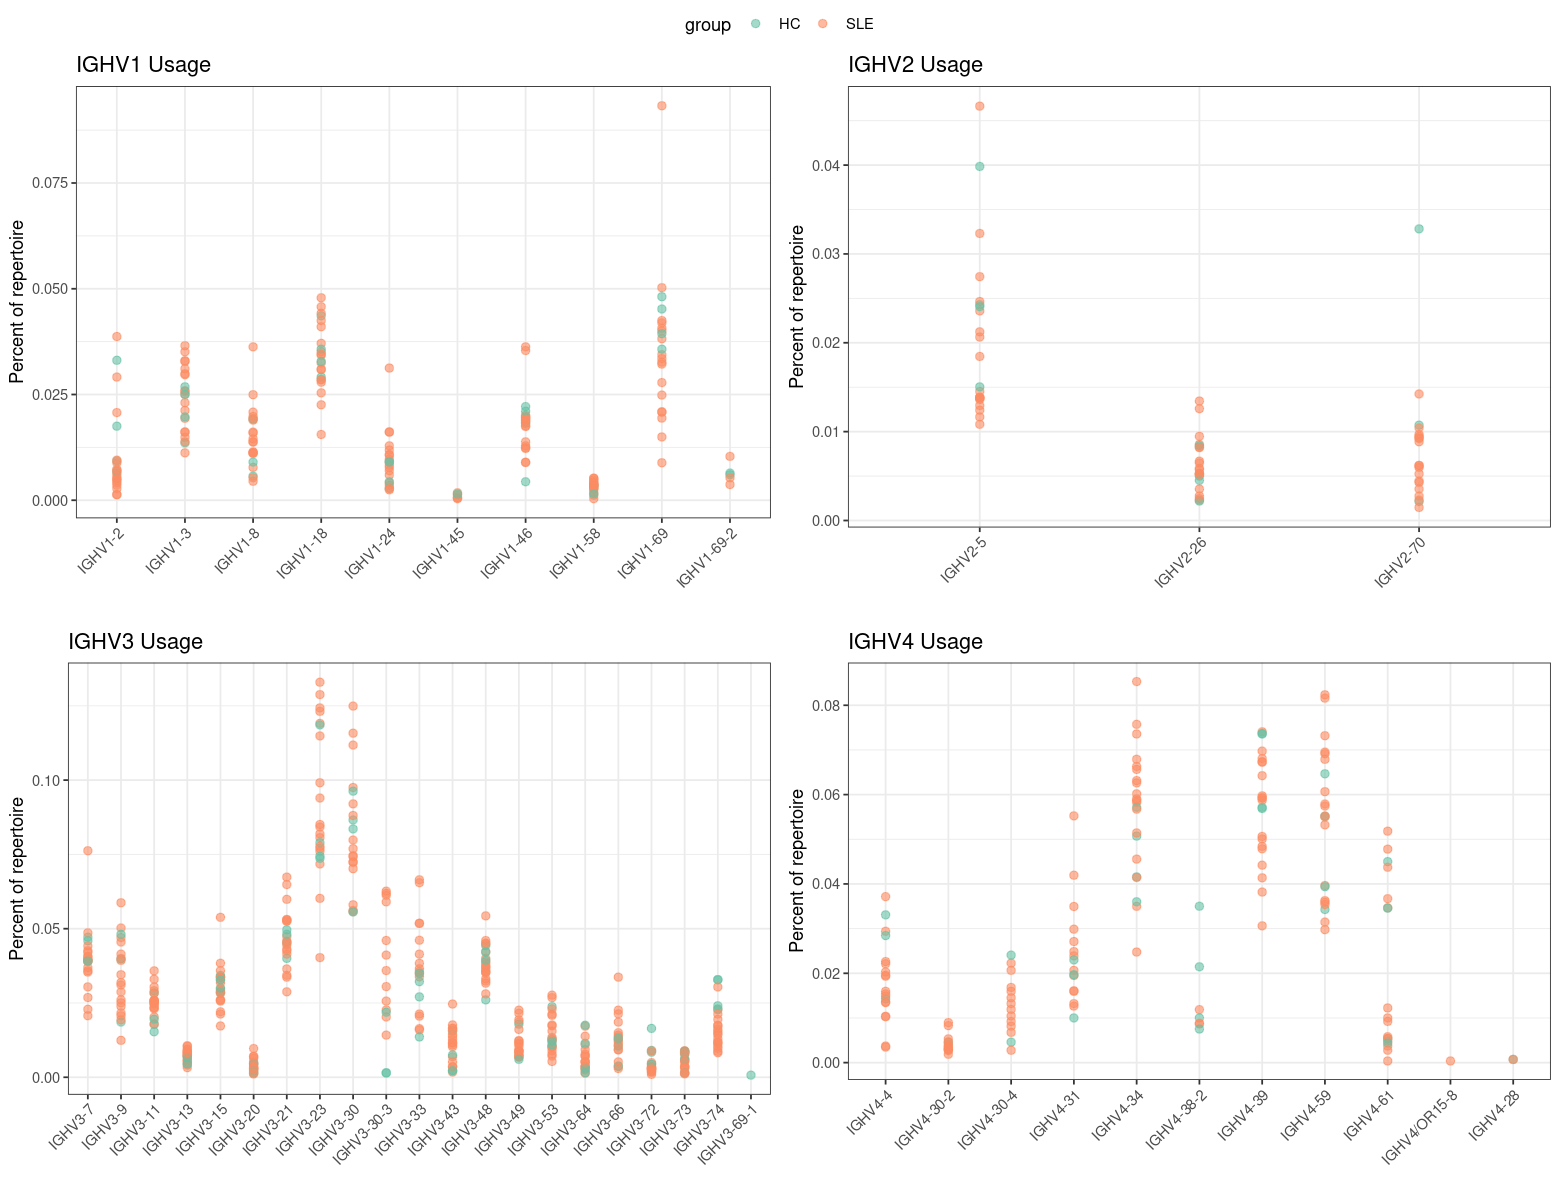

In [193]:
options(repr.plot.width=13, repr.plot.height=10)
ggarrange(g1,g2,g3,g4,common.legend = TRUE)

## use Fisher test

In [109]:
# all_df$v_call_10x %>% head()
# all_df$v_call %>% head()

[1] "IGHV3-74" "IGHV3-30" "IGHV1-8"  "IGHV3-53" "IGHV3-74" "IGHV3-53"

[1] "IGHV3-74*01"                          
[2] "IGHV3-30*04,IGHV3-30*18,IGHV3-30-3*03"
[3] "IGHV1-8*01"                           
[4] "IGHV3-53*01"                          
[5] "IGHV3-74*03"                          
[6] "IGHV3-53*01"

In [118]:
table(all_df$disease)


   HC   SLE 
 4913 32888 

In [ ]:
fisher.result <- data.frame(matrix(NA, ncol =  3, nrow = 0))
for(i in unique(filter_all_df$v_call_10x)){
    this_gene_sle <- filter_all_df %>% filter(disease=='SLE',v_call_10x==i) %>% dim()
    this_gene_hc <- filter_all_df %>% filter(disease=='HC',v_call_10x==i) %>% dim()
    not_this_gene_sle <- table(filter_all_df$disease)[2] - this_gene_sle[1]
    not_this_gene_hc <- table(filter_all_df$disease)[1] - this_gene_hc[1]
    tmp_df <- data.frame("SLE" = c(this_gene_sle[1], not_this_gene_sle),"HC" = c(this_gene_hc[1], not_this_gene_hc), 
                     row.names = c("This_gene", "Other"))
    tmp_fisher <- fisher.test(tmp_df)
    fisher.result <- rbind(fisher.result, c(tmp_fisher$p.value,tmp_fisher$conf.int))
    # print('------------')
}
fisher.result %>% head()

In [200]:
colnames(fisher.result) <- c('p.value','down','up')
rownames(fisher.result) <- unique(filter_all_df$v_call_10x)
fisher.result$gene <- rownames(fisher.result)
fisher.result$mean <- 0.5*(fisher.result$down + fisher.result$up)


In [201]:
fisher.result %<>% filter(mean < 10)

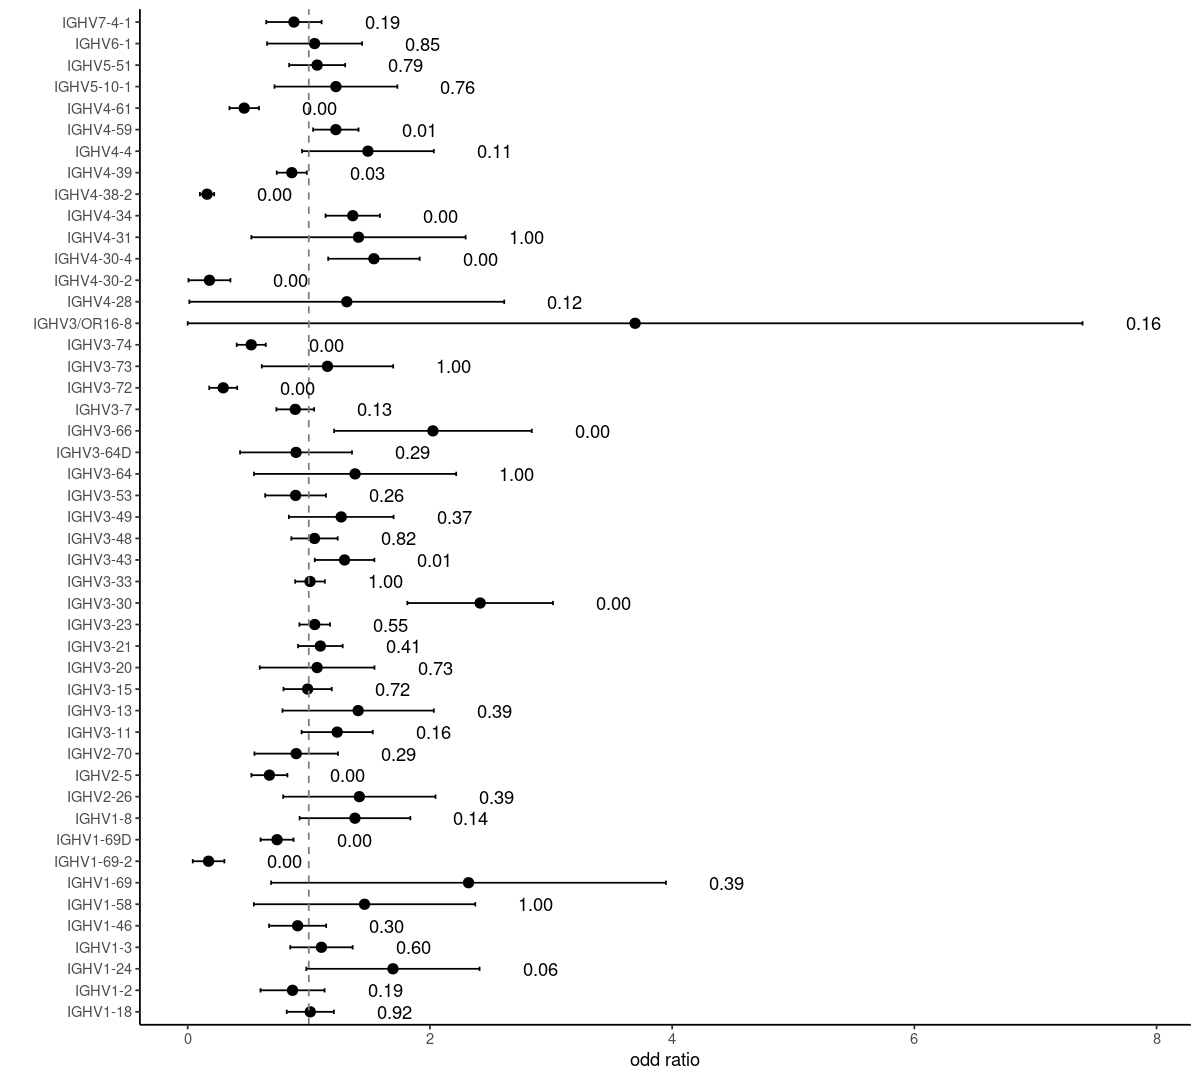

In [202]:
options(repr.plot.width =10, repr.plot.height=9)
ggplot(fisher.result, aes(x=gene, y=mean)) + 
  geom_point(size = 2.5)+ xlab('') + ylab('odd ratio')  +
  geom_errorbar(aes(ymin=down, ymax=up), width=.2,
                position=position_dodge(0.05)) + theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5)) +
geom_hline(aes(yintercept=1), colour="#708090", linetype="dashed") +
  geom_text(aes(x = gene, y = up, label = sprintf("%.2f", p.value)), nudge_y = 0.5)+
    coord_flip() + theme(panel.grid.major=element_line(colour=NA))  + theme_classic() 

## J gene

In [39]:
gene_usage_all_j <- countGenes(filter_all_df, gene="j_call", groups="sample", mode="gene")
options(repr.plot.width=13, repr.plot.height=10)
gene_usage_all_j$gene %>% table()

.
IGHJ1 IGHJ2 IGHJ3 IGHJ4 IGHJ5 IGHJ6 
   22    22    22    22    22    22 

In [40]:
gene_usage_all_j %<>% left_join(unique(filter_all_df[,c('orig.ident','group')]), by = c('sample' = 'orig.ident')) %>% arrange(gene)

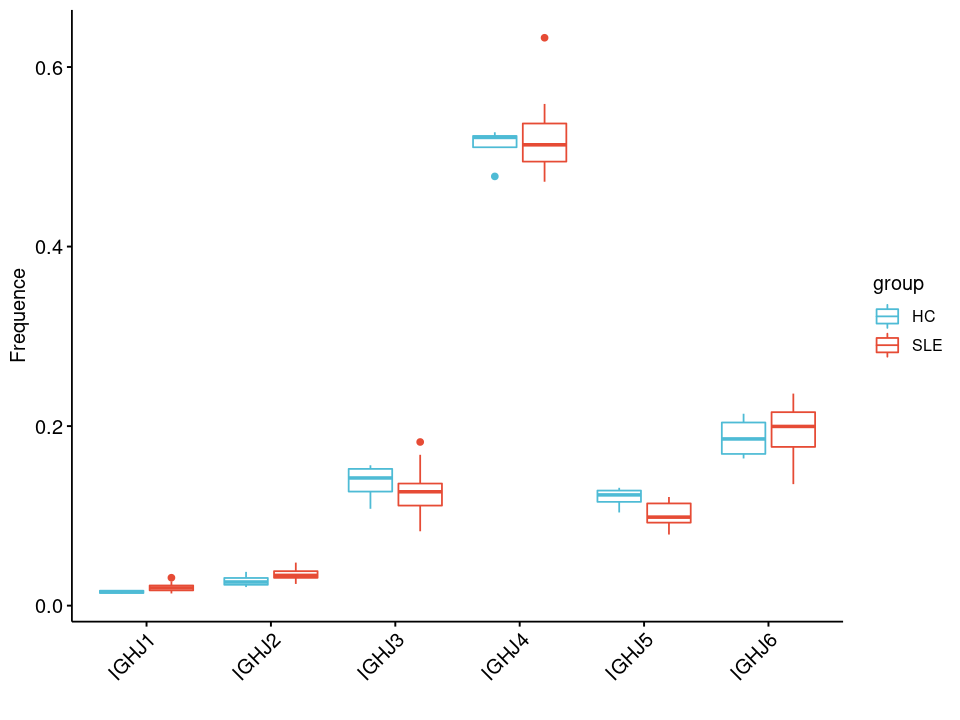

In [51]:
options(repr.plot.width=8, repr.plot.height=6)
ggboxplot(gene_usage_all_j, "gene", "seq_freq", color = "group",palette = c('#4EBBD5','#E64B35'), legend = 'right') +  theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('Frequence')

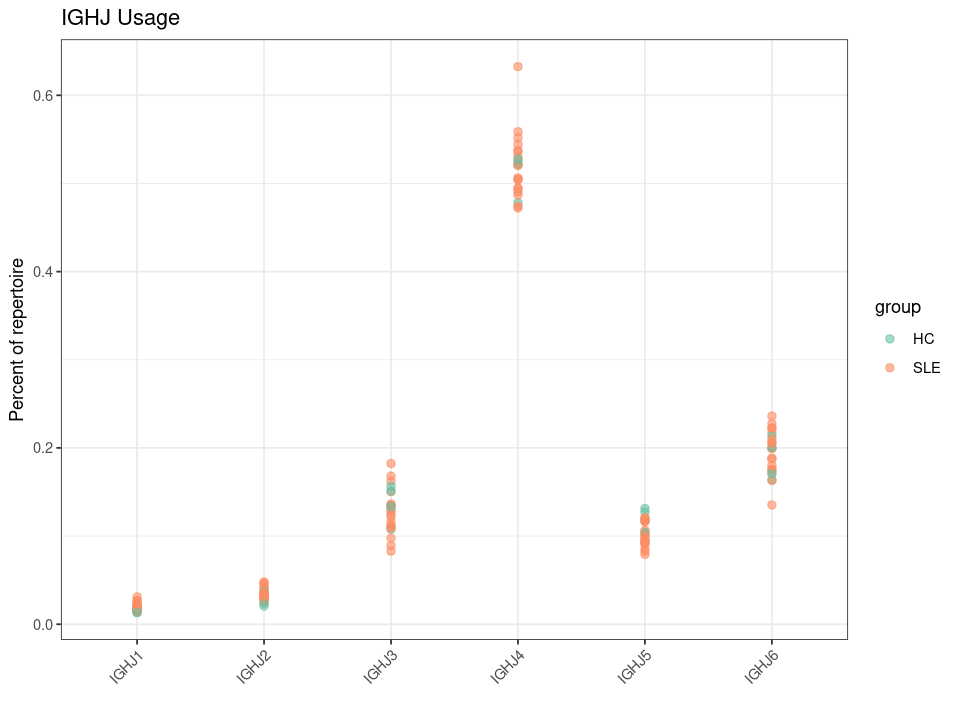

In [205]:
options(repr.plot.width =8, repr.plot.height=6)
gene_usage_all_j %>%
    mutate(gene=factor(gene, levels=sortGenes(unique(gene), method="name"))) %>%
    # filter(getFamily(gene) == "IGHV1") %>% 
    left_join(meta,by = c('sample'='name')) %>%
    ggplot(aes(x=gene, y=seq_freq)) +
    theme_bw() +ggtitle("IGHJ Usage") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    ylab("Percent of repertoire") +xlab("") +
    # scale_y_continuous(labels=percent) +
    scale_color_brewer(palette="Set2") +
    geom_point(aes(color=group), size=2, alpha=0.6)

In [213]:
fisher.result.j <- data.frame(matrix(NA, ncol =  3, nrow = 0))
colnames(fisher.result.j) <- c('p.value','down','up')
for(i in unique(filter_all_df$j_call_10x)){
    this_gene_sle <- filter_all_df %>% filter(disease=='SLE',j_call_10x==i) %>% dim()
    this_gene_hc <- filter_all_df %>% filter(disease=='HC',j_call_10x==i) %>% dim()
    not_this_gene_sle <- table(filter_all_df$disease)[2] - this_gene_sle[1]
    not_this_gene_hc <- table(filter_all_df$disease)[1] - this_gene_hc[1]
    tmp_df <- data.frame("SLE" = c(this_gene_sle[1], not_this_gene_sle),"HC" = c(this_gene_hc[1], not_this_gene_hc), 
                     row.names = c("This_gene", "Other"))
    tmp_fisher <- fisher.test(tmp_df)
    fisher.result.j <- rbind(fisher.result.j, c(tmp_fisher$p.value,tmp_fisher$conf.int))
    # print('------------')
}

In [214]:
colnames(fisher.result.j) <- c('p.value','down','up')
rownames(fisher.result.j) <- unique(all_df$j_call_10x)
fisher.result.j$gene <- rownames(fisher.result.j)
fisher.result.j$mean <- 0.5*(fisher.result.j$down + fisher.result.j$up)

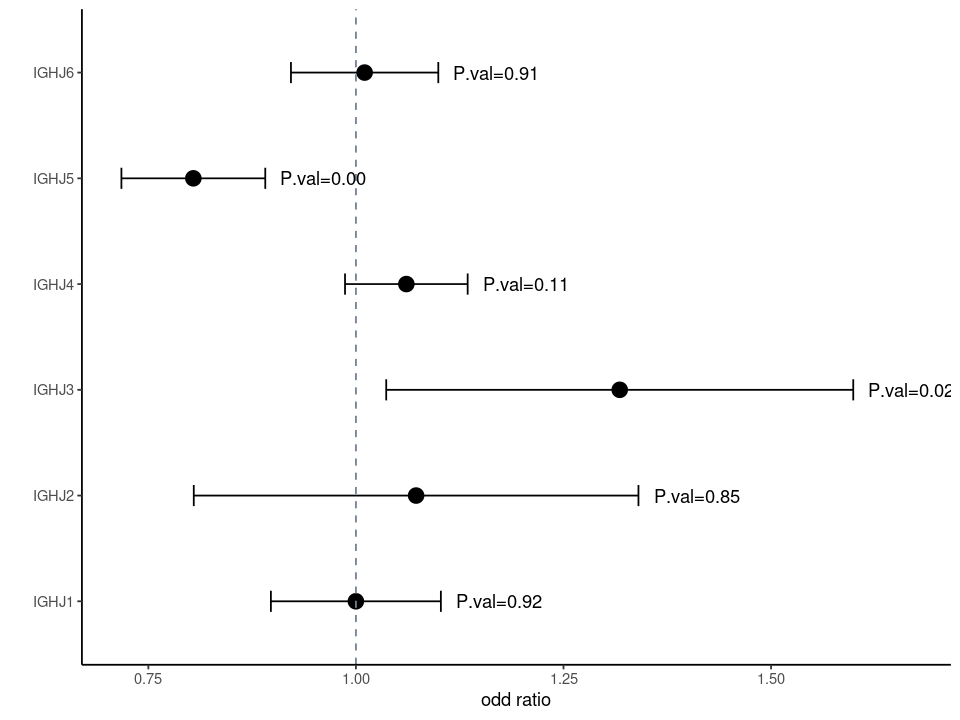

In [216]:
ggplot(fisher.result.j, aes(x=gene, y=mean)) + 
  geom_point(size = 4)+ xlab('') + ylab('odd ratio')  +
  geom_errorbar(aes(ymin=down, ymax=up), width=.2,
                position=position_dodge(0.05)) + theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5)) +
geom_hline(aes(yintercept=1), colour="#708090", linetype="dashed") +
  geom_text(aes(x = gene, y = up, label = paste0('P.val=',sprintf("%.2f", p.value))), 
            nudge_y =0.07 )+
    coord_flip() + theme(panel.grid.major=element_line(colour=NA)) + theme_classic()

# Physics and chemsitry  properties 

In [219]:
all_df %<>% filter(c_call != '')
db_props <- aminoAcidProperties(all_df, seq="junction", trim=TRUE, 
                                label="cdr3")

# The full set of properties are calculated by default
# dplyr::select(db_props[1:3, ], starts_with("cdr3"))

In [229]:
aa_g1 <-  ggboxplot(db_props, "c_call", "cdr3_aa_length", color = "disease",
     palette = c("#4169E1", "#FF8C00"))+
    theme_bw() + stat_compare_means(aes(group = disease), label = "p.signif")
aa_g2 <-  ggboxplot(db_props, "c_call", "cdr3_aa_gravy", color = "disease",
     palette = c("#4169E1", "#FF8C00"))+
    theme_bw() + stat_compare_means(aes(group = disease), label = "p.signif")
aa_g3 <-  ggboxplot(db_props, "c_call", "cdr3_aa_basic", color = "disease",
     palette = c("#4169E1", "#FF8C00"))+
    theme_bw() + stat_compare_means(aes(group = disease), label = "p.signif")
aa_g4 <-  ggboxplot(db_props, "c_call", "cdr3_aa_acidic", color = "disease",
     palette = c("#4169E1", "#FF8C00"))+
    theme_bw() + stat_compare_means(aes(group = disease), label = "p.signif")

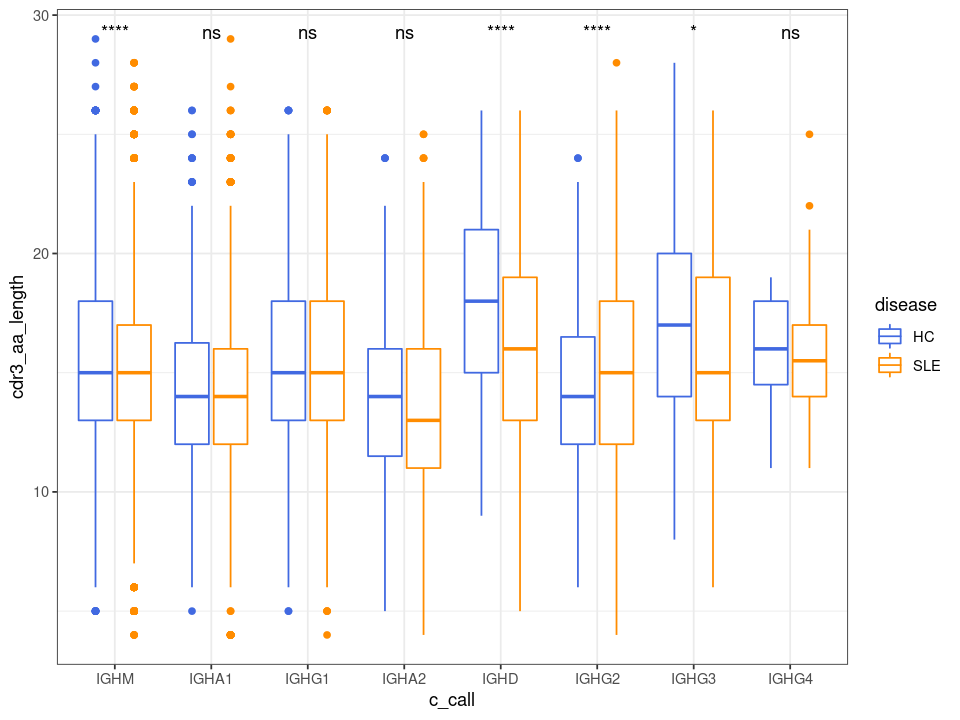

In [256]:
options(repr.plot.width =8, repr.plot.height=6)
aa_g1

$`1`

$`2`

attr(,"class")
[1] "list"      "ggarrange"

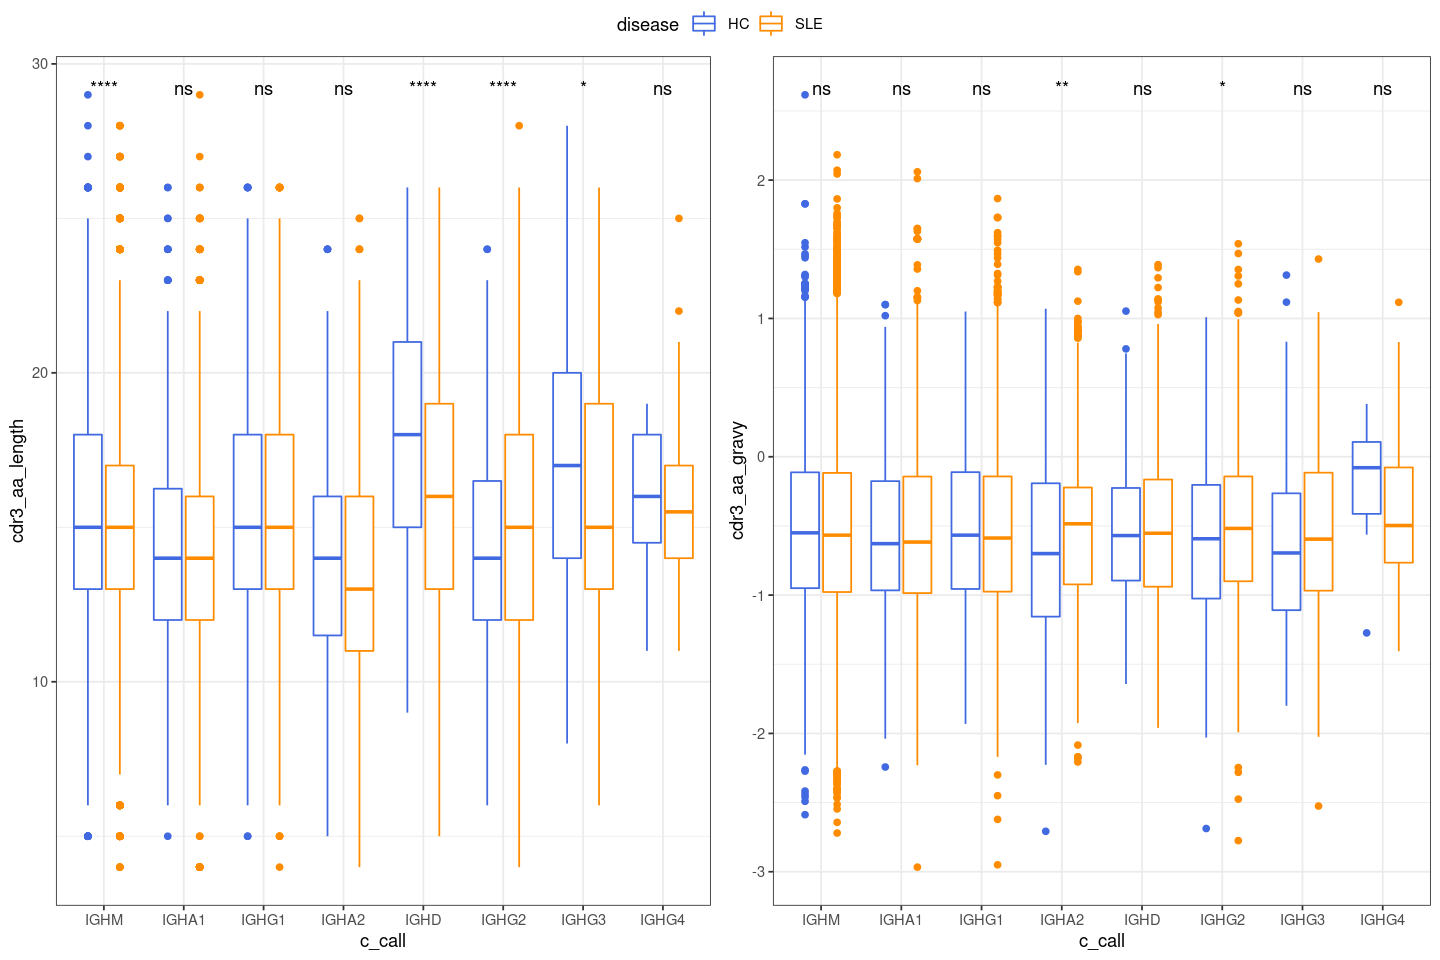

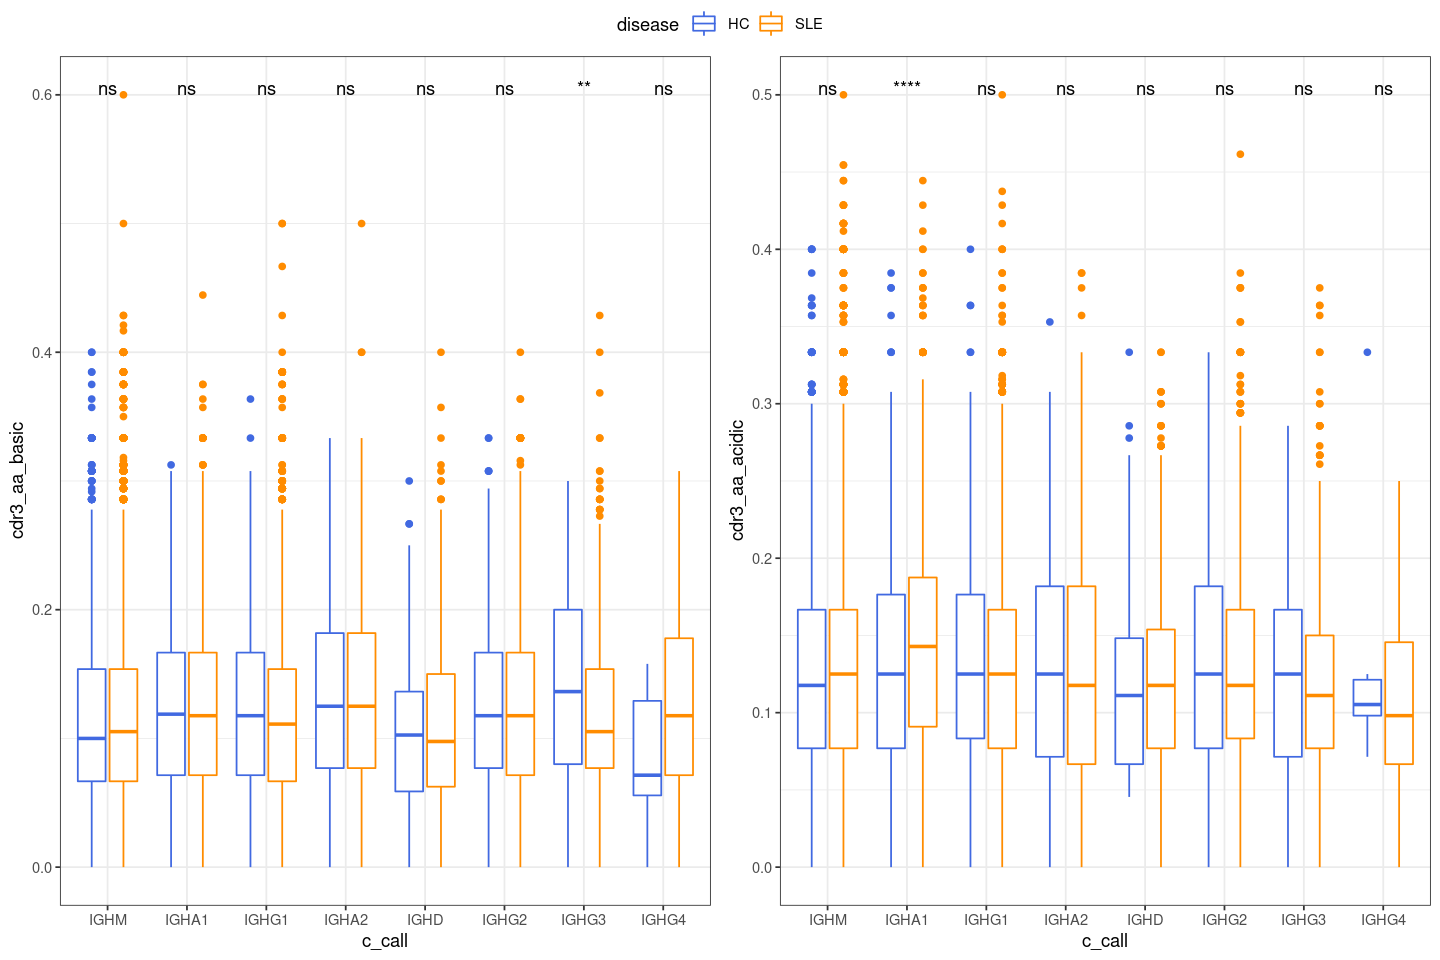

In [232]:
options(repr.plot.width =12, repr.plot.height=8)
# tmp_theme <- theme_bw() + theme(legend.position="bottom")
ggarrange(aa_g1, aa_g2, aa_g3, aa_g4, ncol=2,common.legend = TRUE)

# VH4-34 GENE


In [233]:
bcell_v4_34 <- filter_all_df %>% filter(v_call_10x == 'IGHV4-34') 
table(bcell_v4_34$disease) /table(filter_all_df$disease) 


        HC        SLE 
0.04546642 0.06004950 

In [230]:
# table(bcell_v4_34$disease,bcell_v4_34$subtype) %>% data.frame()
# table(filter_all_df$disease,filter_all_df$subtype)  %>% data.frame()
table(bcell_v4_34$disease,bcell_v4_34$subtype) 
table(filter_all_df$disease,filter_all_df$subtype)

     
      B.IFN-response B.mem B.mem.CD27- B.mem.CXCR3+ B.mem.IGHM+ B.naive
  HC               3    20          17           10          17      99
  SLE            113    43          72          117          38     542
     
      B.transition plasma plasma.IgA plasma.IgG plasmablast
  HC             6      1          0          1           0
  SLE          159     63         14         18          34

     
      B.IFN-response B.mem B.mem.CD27- B.mem.CXCR3+ B.mem.IGHM+ B.naive
  HC              60   625         172          478         419    1628
  SLE           1482  1407        1243         1752         831    8481
     
      B.transition plasma plasma.IgA plasma.IgG plasmablast
  HC           244     16        155          8          22
  SLE         2144   1104        557        441         758

In [235]:
tmp <- filter_all_df %>% filter(subtype=='B.mem.CD27-') 
dim(tmp)

[1] 1415   82

In [237]:
table(tmp$c_call)


      IGHA1 IGHA2  IGHD IGHG1 IGHG2 IGHG3 IGHG4  IGHM 
   23   105     5   102   456   119   137     3   465 

# Choose presure(can not work now)

In [233]:
clones <- collapseClones(all_df, cloneColumn="clone_id", 
                         sequenceColumn="sequence_alignment", 
                         germlineColumn="germline_alignment_d_mask", 
                         regionDefinition=IMGT_V, 
                         method="thresholdedFreq", minimumFrequency=0.6,
                         includeAmbiguous=FALSE, breakTiesStochastic=FALSE, 
                         nproc=24)

ERROR: Error in {: task 268 failed - "Expecting all sequences in the same clone with the same junction lenght."


In [245]:
all_df$clone_id %>% unique() %>% length()

[1] 33224